# I. Introduction

## A. Problem Statment

The goal of this project was to classify news articles into appropriate sections of a newspaper using only linguistic features.

## B. Risks and Assumptions
To make a general classifier that would be effective on any article from any source during any point in history is a huge undertaking, so this one is very specific to the topics in the news in early 2017, and specific to what those sources are reporting on as well. A very general classifier would require frequent re-training to address the problem of "subject drift' [1]. For instance, given the recent presidential election, Donald Trump is featured prominently in almost every newspaper section, but this almost certainly wasn't the case one or two years ago, and may not be the case in the future.

I also relied heavily on tagged datasets and tools developed by the Stanford NLP group. Any inaccuracies that are built into the out-of-the-box versions of their WordNetLemmatizer, Part-of-Speech-Tagger, or NERTagger are therefore built into my own analysis. I believe it is possible to make case-specific modifications to how certain names or locations are tagged, but that was beyond the scope of this project.

## C. Overview
Using a corpus of 4,800 news articles from three sources, I extracted a vocabulary of 5,000 terms, derived named entity counts and sentiment scores, and used these to train Naive Bayes and Stochastic Gradient Descent classifiers to perform with ~85% accuracy in a seven-class discrimination task.

# II. Data Acquisition and Cleaning

## A. Webscraping
Between January 23 - February 18, 2017, I web-scraped full-text articles from *The New York Times* (2,646), *The Washington Post* (1,357), and FoxNews.com (843). I would typically run the scrapers at least twice a day in order to get a fresh batch of articles, since the sites seemed to use Javascript to continuously refresh the end of their homepages, and archives were generally inaccessible. The FoxNews site was particularly difficult, as its Opinion page and Latest page were structured differently from general article pages, necessitating three different scrapers to get articles in each category. In addition, the *New York Times* site required cookie storage, so I implemented a CookieJar object from cookielib as a workaround. For each article, I recorded the title, author, date of publication, source, whatever section the source designated it to come from, and the url.

I stored the articles in a local PostgreSQL database. Each scraper would deposit articles into a staging table, from which only unique articles would be moved into a particular table for that source. I used titles to determine whether or not a particular article had been scraped, as I assumed a source wouldn't publish two stories with the same article in timespan of this project.

In [ ]:
# NytArticleGrabber.py
# webscraper for New York Times articles
#!/usr/bin/env python

import sys
import pandas as pd
from bs4 import BeautifulSoup
import cookielib
import urllib2
import requests
from sqlalchemy import create_engine
from sqlalchemy.orm.session import sessionmaker
import re

def make_soup(url):
    #request = urllib2.Request(url)
    #response = urllib2.urlopen(url)
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html.decode('utf-8', 'ignore'), 'html.parser')

    #soup = BeautifulSoup(urlopen(url).read().decode('utf-8', 'ignore'), 'html.parser')
    results = soup.find_all('div', attrs = {'class': 'story-body'})
    print response.status_code
    return results

def make_dict(results):

    # initialize lists
    titles = []
    dates = []
    links = []
    full_texts = []
    authors = []
    sections = []

    # scrape results into lists
    for x in results:
        # get link
        link = x.find('a')['href']

        # set regex to eliminate interactive features
        match = re.search('^https://www.nytimes.com/20', link)
        if match:
            links.append(link)

    # resoup it
    for link in links:
        all_p = ''
        cj = cookielib.CookieJar()
        opener = urllib2.build_opener(urllib2.HTTPCookieProcessor(cj))
        new_soup = BeautifulSoup(opener.open(link).read().decode('utf-8', 'ignore'), 'html.parser')

        # get the article content
        body = new_soup.find_all('p', attrs = {'class': 'story-body-text story-content'})
        for p in body:
            new_p = p.text.strip()
            all_p = all_p + new_p
        full_texts.append(all_p)

        # get titles
        title = new_soup.find('meta', attrs = {'property': 'og:title'})['content']
        titles.append(title)

        # get authors
        author = new_soup.find('meta', attrs = {'name': 'author'})['content']
        authors.append(author)

        # get sections
        section = new_soup.find('meta', attrs = {'name': 'CG'})['content']
        sections.append(section)

        # get dates
        date = new_soup.find('meta', attrs = {'name': 'pdate'})['content']
        dates.append(date)

    data_dict = {
        'title': titles, 'link': links, 'author': authors, 'body': full_texts,
        'section': sections, 'date': dates
    }
    return data_dict

def make_dataframe(data_dict):
    df = pd.DataFrame(data_dict)
    return df


def main():
    section_list = [
    'us','health','opinion','science','sports',
    'arts','world','technology']
    for x in section_list:
        url = 'http://www.nytimes.com/section/' + x
        results = make_soup(url)
        data_dict = make_dict(results)
        df = make_dataframe(data_dict)

        # create engine
        engine = create_engine('postgresql://teresaborcuch@localhost:5433/capstone')
        Session = sessionmaker(bind=engine)
        session = Session()

        # clear staging
        clear_staging_query = 'DELETE FROM nyt_staging *;'
        engine.execute(clear_staging_query)
        session.commit()

        # add df to staging
        df.to_sql('nyt_staging', engine, if_exists = 'append', index = False)

        # move unique rows from staging to ny_times
        move_unique_query = '''
        INSERT INTO ny_times (title, date, author, body, link, section)
        SELECT title, date, author, body, link, section
        FROM nyt_staging
        WHERE NOT EXISTS (SELECT title, date, author, body, link, section
        FROM ny_times
        WHERE ny_times.title = nyt_staging.title);
        '''
        engine.execute(move_unique_query)
        session.commit()
        session.close()

        print "{} done".format(x)


if __name__ == "__main__":
    main()


In [ ]:
# WpArticleGrabber.py
# webscraper for Washington Post articles
#!/usr/bin/env python

import sys
import pandas as pd
from bs4 import BeautifulSoup
import cookielib
import urllib2
import requests
from sqlalchemy import create_engine
from sqlalchemy.orm.session import sessionmaker
import re

def make_soup(url):
    #url = 'https://www.washingtonpost.com/politics'
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html.decode('utf-8', 'ignore'), 'html.parser')
    results = soup.find_all('h3', attrs = {'class': ''})
    print response.status_code
    return results

def make_dict(results):
# initialize lists
    titles = []
    dates = []
    links = []
    bodies = []
    authors = []
    sections = []

    for x in results:
        link = x.find('a')['href']
        match1 = re.search('^https://www.washingtonpost.com/video', link)
        match2 = re.search('story.html', link)
        if not match1 and match2:
            links.append(link)

    # resoup link
    for link in links:
        response = requests.get(link)
        html = response.content
        new_soup = BeautifulSoup(html.decode('utf-8', 'ignore'), 'html.parser')

        # get title
        title = new_soup.find('title').text.strip().replace(' - The Washington Post','')
        titles.append(title)

        # get body
        all_p = ''
        body = new_soup.find('article', itemprop = 'articleBody')
        paragraphs = body.find_all('p')
        for p in paragraphs:
            new_p = p.text.strip().encode('ascii', 'ignore')
            all_p = all_p + new_p
        bodies.append(all_p)

        # get author
        author = ''
        author_list = new_soup.find_all('span', attrs = {'itemprop': 'name'})
        for a in author_list:
            a = a.text.strip()
            author = author + ',' + a
        authors.append(author)

        # get date
        date = new_soup.find('span', attrs = {'itemprop': 'datePublished'})['content']
        dates.append(date)

        # get section
        scripts = new_soup.find_all('script')
        pattern = 'var commercialNode'

        for script in scripts:
            #if (pattern.match(str(script.string))):
            match = re.search(pattern, str(script))
            if match:
                text = script.text.strip()
                text_list = text.split(';')
                for x in text_list:
                    match = re.search(pattern, x)
                    if match:
                        section = x.replace('var commercialNode=', '').replace('"','')


        sections.append(section)

    data_dict = {
        'title': titles, 'link': links, 'author': authors,
        'body': bodies, 'section': sections, 'date': dates
    }
    return data_dict

def make_df(data_dict):
    df = pd.DataFrame(data_dict)
    return df

def main():
    section_list = [
    'world','national','politics','entertainment',
    'business', 'lifestyle','opinions','sports']
    for x in section_list:
        url = 'http://www.washingtonpost.com/' + x

        results = make_soup(url)
        try:
            data_dict = make_dict(results)
            df = make_df(data_dict)
            # create engine
            engine = create_engine('postgresql://teresaborcuch@localhost:5433/capstone')
            Session = sessionmaker(bind=engine)
            session = Session()
            # clear staging
            clear_staging_query = 'DELETE FROM wp_staging *;'
            engine.execute(clear_staging_query)
            session.commit()
            # add df to staging
            df.to_sql('wp_staging', engine, if_exists = 'append', index = False)
            # move unique rows from staging to ny_times
            move_unique_query = '''
            INSERT INTO washington_post (title, date, author, body, link, section)
            SELECT title, date, author, body, link, section
            FROM wp_staging
            WHERE NOT EXISTS (SELECT title, date, author, body, link, section
            FROM washington_post
            WHERE washington_post.title = wp_staging.title);
            '''
            engine.execute(move_unique_query)
            session.commit()
            session.close()
            print "Done"
        except AttributeError:
            pass

if __name__ == "__main__":
    main()


In [ ]:
# FoxLatestGrabber.py
# webscraper for articles on FoxNews Latest page
#!/usr/bin/env python

import sys
import pandas as pd
from bs4 import BeautifulSoup
import cookielib
import urllib2
import requests
from sqlalchemy import create_engine
from sqlalchemy.orm.session import sessionmaker
import re

def make_soup(url):
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html.decode('utf-8', 'ignore'), 'html.parser')
    results = soup.find_all('li', attrs = {'class': 'nav-column'})
    print response.status_code
    return results

def make_dict(results):
    # create lists to hold results
    links = []
    titles = []
    dates = []
    sections = []
    bodies = []
    authors = []

    # get link
    for x in results:
        link = x.find('a')['href']
        links.append(link)

    # re-soup it
    for link in links:
        match = re.search('^http://', link)
        if not match:
            link = 'http://insider.foxnews.com' + link
        response = requests.get(link)
        html = response.content
        new_soup = BeautifulSoup(html.decode('utf-8', 'ignore'), 'html.parser')

        # get title
        title = new_soup.find('title').text.strip()
        titles.append(title)

        # get date
        date = new_soup.find('meta', attrs = {'name': 'dc.date'})['content']
        dates.append(date)

        # get section
        section = new_soup.find('meta', attrs = {'name': 'dc.subject'})['content']
        sections.append(section)

        # get author
        author = new_soup.find('span', attrs = {'id': 'author'}).text.strip()
        authors.append(author)

        # get body
        all_p = ''
        body = new_soup.find('div', attrs = {'class': 'articleBody'})
        paragraphs = body.find_all('p')
        for p in paragraphs:
            p = p.text.strip().encode('ascii','ignore')
            all_p = all_p + p
        bodies.append(all_p)

        my_dict = {
        'title': titles, 'link': links, 'author': authors, 'body': bodies,
        'section': sections, 'date': dates
    }
    return my_dict

def make_df(my_dict):
    df = pd.DataFrame(my_dict)
    return df

def main():
    url = 'http://insider.foxnews.com/latest'
    results = make_soup(url)
    data_dict = make_dict(results)
    df = make_df(data_dict)

    engine = create_engine('postgresql://teresaborcuch@localhost:5433/capstone')
    Session = sessionmaker(bind=engine)
    session = Session()
    # clear staging
    clear_staging_query = 'DELETE FROM fox_staging *;'
    engine.execute(clear_staging_query)
    session.commit()
    # add df to staging
    df.to_sql('fox_staging', engine, if_exists = 'append', index = False)
    # move unique rows from staging to ny_times
    move_unique_query = '''
    INSERT INTO fox_news (title, date, author, body, link, section)
    SELECT title, date, author, body, link, section
    FROM fox_staging
    WHERE NOT EXISTS (SELECT title, date, author, body, link, section
    FROM fox_news
    WHERE fox_news.title = fox_staging.title);
    '''
    engine.execute(move_unique_query)
    session.commit()
    session.close()
    print "Done"

if __name__ == "__main__":
    main()


In [ ]:
# FoxOpinionGrabber.py
# webscraper for FoxNews opinion articles
#!/usr/bin/env python

import sys
import pandas as pd
from bs4 import BeautifulSoup
import cookielib
import urllib2
import requests
from sqlalchemy import create_engine
from sqlalchemy.orm.session import sessionmaker
import re

def make_soup(url):
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')
    results = soup.find_all('article')
    print response.status_code
    return results

def make_dict(results):
    # create lists
    links = []
    titles = []
    sections = []
    authors = []
    bodies = []
    dates = []

    # get link
    for x in results:
        h1 = x.find('h1')
        link = h1.find('a')['href']
        links.append(link)

    for link in links:
        url = 'http://www.foxnews.com' + link
        response = requests.get(url)
        html = response.content
        new_soup = BeautifulSoup(html, 'html.parser')

        # get title
        title = new_soup.find('title').text.strip().replace('| Fox News', '')
        titles.append(title)

        # get date
        date = new_soup.find('meta', attrs = {'name': 'dc.date'})['content']
        dates.append(date)

        # get author
        author_div = new_soup.find('div', attrs = {'class': 'm author'})
        try:
            author = author_div.find('img')['alt']
        except AttributeError:
            author = "None found"
        authors.append(author)

        # get body
        all_p = ''
        body = new_soup.find('div', attrs = {'class': 'article-text'})
        paragraphs = body.find_all('p')
        for p in paragraphs:
            p = p.text.strip().encode('ascii','ignore')
            all_p = all_p + p
        bodies.append(all_p)

        # get section
        section = new_soup.find('h2', attrs = {'class': 'section-title'}).text.strip()
        sections.append(section)

    my_dict = {
        'title': titles, 'link': links, 'author': authors, 'body': bodies,
        'section': sections, 'date': dates
    }
    return my_dict

def make_df(my_dict):
    df = pd.DataFrame(my_dict)
    return df

def main():
    url = 'http://foxnews.com/opinion.html'
    results = make_soup(url)
    data_dict = make_dict(results)
    df = make_df(data_dict)

    engine = create_engine('postgresql://teresaborcuch@localhost:5433/capstone')
    Session = sessionmaker(bind=engine)
    session = Session()
    # clear staging
    clear_staging_query = 'DELETE FROM fox_staging *;'
    engine.execute(clear_staging_query)
    session.commit()
    # add df to staging
    df.to_sql('fox_staging', engine, if_exists = 'append', index = False)
    # move unique rows from staging to ny_times
    move_unique_query = '''
    INSERT INTO fox_news (title, date, author, body, link, section)
    SELECT title, date, author, body, link, section
    FROM fox_staging
    WHERE NOT EXISTS (SELECT title, date, author, body, link, section
    FROM fox_news
    WHERE fox_news.title = fox_staging.title);
    '''
    engine.execute(move_unique_query)
    session.commit()
    session.close()
    print "Done"

if __name__ == "__main__":
    main()


In [ ]:
# FoxMiscGrabber.py
# webscraper for all other FoxNews articles
#!/usr/bin/env python

import sys
import pandas as pd
from bs4 import BeautifulSoup
import urllib2
import requests
from sqlalchemy import create_engine
from sqlalchemy.orm.session import sessionmaker
import re

def make_soup(url):
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')
    results = soup.find_all('article')
    print response.status_code
    return results

def make_dict(results):
    links = []
    authors = []
    dates = []
    bodies = []
    titles = []
    sections = []

    for x in results:
        link = x.find('a')['href']
        match1 = re.search('^http://', link)
        match2 = re.search('/slideshow', link)
        match3 = re.search('/health.html', link)
        if not match1 and not match2 and not match3:
            links.append(link)

    for link in links:
        url = 'http://www.foxnews.com' + link
        response = requests.get(url)
        html = response.content
        new_soup = BeautifulSoup(html, 'html.parser')

        # get title
        title = new_soup.find('title').text.strip().replace('| Fox News','')
        titles.append(title)

        # get body
        all_p = ''
        body = new_soup.find('div', attrs = {'class': 'article-text'})
        paragraphs = body.find_all('p')
        for p in paragraphs:
            p = p.text.strip().encode('ascii','ignore')
            all_p = all_p + p
        bodies.append(all_p)

        # get date
        date = new_soup.find('meta', attrs = {'name': 'dc.date'})['content']
        dates.append(date)

        # get section
        section = new_soup.find('meta', attrs = {'name': "prism.section"})['content']
        sections.append(section)

        # get author
        author_div = new_soup.find('div', attrs = {'class': 'article-info'})
        try:
            author = author_div.find('p').text.strip()
        except AttributeError:
            author = "None found"
        authors.append(author)

    my_dict = {
        'title': titles, 'link': links, 'author': authors, 'body': bodies,
        'section': sections, 'date': dates
    }
    return my_dict

def make_df(my_dict):
    df = pd.DataFrame(my_dict)
    return df

def main():
    urls = [
    'http://foxnews.com/health.html',
    'http://foxnews.com/entertainment.html',
    'http://foxnews.com/tech.html',
    'http://foxnews.com/science.html']

    for url in urls:
        results = make_soup(url)
        try:
            data_dict = make_dict(results)
            df = make_df(data_dict)

            engine = create_engine('postgresql://teresaborcuch@localhost:5433/capstone')
            Session = sessionmaker(bind=engine)
            session = Session()
            # clear staging
            clear_staging_query = 'DELETE FROM fox_staging *;'
            engine.execute(clear_staging_query)
            session.commit()
            # add df to staging
            df.to_sql('fox_staging', engine, if_exists = 'append', index = False)
            # move unique rows from staging to ny_times
            move_unique_query = '''
            INSERT INTO fox_news (title, date, author, body, link, section)
            SELECT title, date, author, body, link, section
            FROM fox_staging
            WHERE NOT EXISTS (SELECT title, date, author, body, link, section
            FROM fox_news
            WHERE fox_news.title = fox_staging.title);
            '''
            engine.execute(move_unique_query)
            session.commit()
            session.close()
            print "{} done".format(url)
        except AttributeError:
            pass

if __name__ == "__main__":
    main()


## B. Data Cleaning and Standardization

Since each source has its own uniquely named sections with multiple subsections, I had to make judgments of which articles should be grouped together. Initially, I had eleven categories: world news, politics, entertainment, business, technology, science, health, sports, opinion, education, and other. I decided to combine science and health, as many of the science articles were related to the human body anyways, and merged business and technology, as most of the business articles were about technology companies. I dropped 'other' from analysis, since this was an amalgam of local news, obituaries, and other miscellany, as well as education, due to low numbers. This left me with the final seven categories: world, politics, entertainment, science/health, business/technology, sports, and opinion.

To handle this operation, merge the three tables from the database, and to conduct other maintenance cleaning tasks, like standardizing encoding, dropping the "| Fox News" suffix from certain titles, resetting the index, and dropping articles that were too short, I created a utility class **ArticleData**. Upon instantiation, an **ArticleData** object pulled all articles currently in the database, formatted their sections as described, and returned a dataframe containing title, date, condensed source, full-text article body, and the original source.

In [ ]:
class ArticleData():

    '''
    Usage:
    >>> from articledata import *
    >>> data = ArticleData().call()
    >>> data = get_sent_scores(data = data)
    >>> topic_data = evaluate_topic(data = data, section = 'opinion', source = 'NYT', topic = 'healthcare')
    >>> data = count_entities(data = data, title = True)
    >>> people_dict, place_dict = evaluate_entities(data = data, section = 'opinion', source = 'NYT')
    '''


    def __init__(self): pass

    def call(self):
        engine = create_engine('postgresql://teresaborcuch@localhost:5433/capstone')

        # get data from all three tables and add source column
        query1 = "SELECT DISTINCT ON(title) title, date, body, section FROM fox_news;"
        fox_data = pd.read_sql(query1, engine)
        fox_data['source'] = ['Fox']*len(fox_data)

        query2 = "SELECT DISTINCT ON(title) title, date, body, section FROM ny_times;"
        nyt_data = pd.read_sql(query2, engine)
        nyt_data['source'] = ['NYT'] * len(nyt_data)

        query3 = "SELECT DISTINCT ON(title) title, date, body, section FROM washington_post;"
        wp_data = pd.read_sql(query3, engine)
        wp_data['source'] = ['WP']*len(wp_data)

        # merge the dataframes into one big one
        data = pd.concat([nyt_data, fox_data, wp_data], axis = 0)

        # drop those with empty or suspiciously short bodies
        problem_rows = []
        for i, row in data.iterrows():
            try:
                if len(row[2]) < 200:
                    problem_rows.append(row.name)
            except TypeError:
                problem_rows.append(row.name)

        data = data.drop(data.index[problem_rows])

        # fix the dates
        new_dates = []
        for x in data['date']:
            if type(x) == int:
                x = str(x)
                x = (x[:4] + '-' + x[4:6] + '-' + x[6:8]).replace(' 00:00:00','')
                x = datetime.strptime(x, '%Y-%m-%d')
                new_dates.append(x)
            else:
                x = str(x).replace(' 00:00:00','')
                x = datetime.strptime(x, '%Y-%m-%d')
                new_dates.append(x)

        data['date'] = new_dates

        # eliminate | Fox News from titles
        
        clean_titles = []
        for x in data['title']:
            match = re.search('\|.*$', x)
            if match:
                clean_x = re.sub('\|.*$','',x)
                clean_titles.append(clean_x)
            else:
                clean_titles.append(x)
        data['title'] = clean_titles


        # create the condensed sections
        
        def condense_section(x):
            if 'world' in x:
                section = 'world'
            elif 'pinion' in x:
                section = 'opinion'
            elif ('business' in x) or ('tech' in x):
                section = 'bus_tech'
            elif ('entertain' in x) or ('art' in x) or ('theater' in x) or ('book' in x) or ('movie' in x) or ('travel' in x) or ('fashion' in x) or ('style' in x) or ('dining' in x):
                section = 'entertainment'
            elif 'sport' in x:
                section = 'sports'
            elif ('health' in x) or ('science' in x) or ('well' in x):
                section = 'sci_health'
            elif ('education' in x):
                section = 'education'
            elif ('politic' in x) or ('us' in x):
                section = 'politics'
            else:
                section = 'other'
            return section

        data['condensed_section'] = [condense_section(x) for x in data['section']]

        # drop other and education sections
        
        mask1 = data['condensed_section'] != 'other'
        mask2 = data['condensed_section'] != 'education'
        data = data[mask1 & mask2]

        return data


In [3]:
from articledata import ArticleData
data = ArticleData().call()

In [4]:
data.head()

,title,date,body,section,source,condensed_section
0,#GrammysSoWhite Came to Life. Will the Awards ...,2017-02-13,Before the rapper Q-Tip of A Tribe Called Ques...,arts,NYT,entertainment
1,$5 Million for a Super Bowl Ad. Another Millio...,2017-01-29,"This month, Anheuser-Busch InBev hosted a doze...",business,NYT,bus_tech
2,"$60,000 in Tuition, and My Son Wants to Become...",2017-01-12,My wife and I are spending a fortune to send o...,fashion,NYT,entertainment
3,"1 Patient, 7 Tumors and 100 Billion Cells Equa...",2016-12-07,The remarkable recovery of a woman with advanc...,health,NYT,sci_health
6,14 TV Shows That Broke Ground With Gay and Tra...,2017-02-16,Last year was a remarkable time when it came t...,arts,NYT,entertainment


# III. Feature Engineering

## A. Sentiment Analysis

Sentiment analysis approximates the overall polarity of a text by scoring its positive, negative and neutral words on a scale from -1 to 1. To score each article title or body, I used a compute_score function that lemmatizes each word using NLTK's WordNetLemmatizer, and then tags each word with its part of speech using the PerceptronTagger. This allows each word to be matched to a synset, or synonym set in SentiwordNet, a resource that maps thousands of English words to their sentiment scores. Although a particular word can potentially belong to multiple synsets, depending on its usage in a sentence, I opted to just select the first one, which may have compromised accuracy a bit.

The compute_score function can be applied to data directly for exploratory data analysis of sentiment, or the data can be transferred to a SentimentPlotter object (see Section IV.C Plotting with Highcharts, below).

In [ ]:
def compute_score(sentence):
        tagger = PerceptronTagger()
        taggedsentence = []
        sent_score = []
        taggedsentence.append(tagger.tag(sentence.split()))
        wnl = nltk.WordNetLemmatizer()
        for idx, words in enumerate(taggedsentence):
            for idx2, t in enumerate(words):
                newtag = ''
                lemmatizedsent = wnl.lemmatize(t[0])
                if t[1].startswith('NN'):
                    newtag = 'n'
                elif t[1].startswith('JJ'):
                    newtag = 'a'
                elif t[1].startswith('V'):
                    newtag = 'v'
                elif t[1].startswith('R'):
                    newtag = 'r'
                else:
                    newtag = ''
                if (newtag != ''):
                    synsets = list(swn.senti_synsets(lemmatizedsent, newtag))
                    score = 0.0
                    if (len(synsets) > 0):
                        for syn in synsets:
                            score += syn.pos_score() - syn.neg_score()
                        sent_score.append(score / len(synsets))
            if (len(sent_score)==0 or len(sent_score)==1):
                return (float(0.0))
            else:
                return (sum([word_score for word_score in sent_score]) / (len(sent_score)))
    data['SA_body'] = [compute_score(x) for x in data['body']]
    data['SA_title'] = [compute_score(x) for x in data['title']]

    return data

## B. Named Entity Recognition

Named entity recognition seeks to identify people, places, times, dates, or other elements from text. I utilized the Stanford NLP group's three-class model and an NLTK wrapper to identify people and places in each article. Additionally, NLTK comes with a corpus of tagged male and female names, so I counted how many men and women were mentioned in article titles and bodies. I wrote a count_entities function that tokenizes a text, uses Stanford's NERTagger to tag all people and places, and then counts them. However, I have to note that if a name isn't within the name corpus, it's possible for the function recognize and count people, but not know whether they are male or female, so these counts have varying levels of accuracy.

Additionally, to track which people and places were most common in each section, I wrote an evaluate_entities function that returns a dictionary of each entity and its frequency.

In [ ]:
def count_entities(data = None, title = True):
    # set up tagger
    os.environ['CLASSPATH'] = "/Users/teresaborcuch/stanford-ner-2013-11-12/stanford-ner.jar"
    os.environ['STANFORD_MODELS'] = '/Users/teresaborcuch/stanford-ner-2013-11-12/classifiers'
    st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

    tagged_titles = []
    persons = []
    places = []

    if title:

        for x in data['title']:
            tokens = word_tokenize(x)
            tags = st.tag(tokens)
            tagged_titles.append(tags)

        for pair_list in tagged_titles:
            person_count = 0
            place_count = 0
            for pair in pair_list:
                if pair[1] == 'PERSON':
                    person_count +=1
                elif pair[1] == 'LOCATION':
                    place_count +=1
                else:
                    continue
            persons.append(person_count)
            places.append(place_count)


        data['total_persons_title'] = persons
        data['total_places_title'] = places

    else:
        for x in data['body']:
            tokens = word_tokenize(x)
            tags = st.tag(tokens)
            tagged_titles.append(tags)

        for pair_list in tagged_titles:
            person_count = 0
            place_count = 0
            for pair in pair_list:
                if pair[1] == 'PERSON':
                    person_count +=1
                elif pair[1] == 'LOCATION':
                    place_count +=1
                else:
                    continue
            persons.append(person_count)
            places.append(place_count)

        data['total_persons_body'] = persons
        data['total_places_body'] = places

    return data

def evaluate_entities(data = None, section = None, source = None):
    section_mask = (data['condensed_section'] == section)
    source_mask = (data['source'] == source)

    if section and source:
        masked_data = data[section_mask & source_mask]

    elif section:
        masked_data = data[section_mask]

    elif source:
        masked_data = data[source_mask]

    else:
        masked_data = data

    # set up tagger
    os.environ['CLASSPATH'] = "/Users/teresaborcuch/stanford-ner-2013-11-12/stanford-ner.jar"
    os.environ['STANFORD_MODELS'] = '/Users/teresaborcuch/stanford-ner-2013-11-12/classifiers'
    st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')
    # dictionaries to hold counts of entities
    person_dict = {}
    place_dict = {}

    for x in masked_data['body']:
        tokens = word_tokenize(x)
        tags = st.tag(tokens)
        for pair in tags:
            if pair[1] == 'PERSON':
                if pair[0] not in person_dict.keys():
                    person_dict[pair[0]] = 1
                else:
                    person_dict[pair[0]] +=1
            elif pair[1] == 'LOCATION':
                if pair[0] not in place_dict.keys():
                    place_dict[pair[0]] = 1
                else:
                    place_dict[pair[0]] += 1

    return person_dict, place_dict

In [1]:
# code for evaluate entities

## C. Custom Transformers

To actually derive these features for article titles or bodies, I wrote two transformer classes, **TitleTransformer** and **BodyTransformer**. Each of these classes inherited the methods from Sci-kit Learn's BaseEstimator and TransformerMixin classes, which allows them to be utilized in pipelines. Using the fit_transform method from one of these scalers on an **ArticleData** object returns a dataframe containing sentiment scores, as well as the number of people, number of men and women, and number of places in each article.

In [ ]:
class TitleTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        persons, places, males, females = count_entities(X['title'])
        ss = np.asarray([compute_score(x) for x in X['title']])

        title_array = map(list,(zip(persons, places, males, females, ss))) #ss

        return pd.DataFrame(title_array, columns = ['title_persons', 'title_places',
                                                    'title_men', 'title_women', 'title_ss'])
    
class BodyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self

    def transform(self, X):

        ss = [compute_score(x) for x in X['body']]
        persons, places, males, females = count_entities(X['body'])

        body_array = map(list,(zip(persons, places, males, females,ss)))
        return pd.DataFrame(body_array, columns = ['body_persons', 'body_places',
                                                   'body_men', 'body_women', 'body_ss'])

In [5]:
# Example of TitleTransformer in action
from newsanalyzer import TitleTransformer, BodyTransformer

test_data = data[:5]

tt = TitleTransformer()
test_data_tt = tt.fit_transform(test_data)
test_data_tt

,title_persons,title_places,title_men,title_women,title_ss
0,0,0,0,0,0.052484
1,0,0,0,0,-0.023148
2,0,0,0,0,0.041667
3,0,0,0,0,-0.034722
4,0,0,0,0,0.084028


In [7]:
# BodyTransformer in action
bt = BodyTransformer()
test_data_bt = bt.fit_transform(test_data)
test_data_bt

,body_persons,body_places,body_men,body_women,body_ss
0,42,5,0,0,-0.000025
1,17,8,0,0,0.016240
2,13,2,0,0,0.020668
3,24,9,0,0,0.000946
4,80,4,0,0,0.027508


## D. Tf-Idf Vectors

The vast majority of the feature set comes from Sci-kit Learn's TfidfVectorizer with a custom preprocessor. Tf-idf stands for "Term Frequency-Inverse Document Frequency" and weighs the frequency with which a word appears in a given document against how common it is in the entire corpus. So a word that occurs very often in one document, but is rare in the corpus would have a higher Tf-idf value.

The TfidfVectorizer has parameters for preprocessing, stopwords, and a n-gram range. I modified a custom preprocessor, the 'tokenize' function, that utilizes NLTK's lemmatizing capabilities, eliminates punctuation and stopwords, and strips accents [2]. Lemmatization is a process that reduces words to their lemmas, or base forms. For instance, lemmatization would reduce "is", "am" and "were" to "be", as they are all diverse forms of the same root verb. 

I used ngram_range = (1,2) to include both bigrams and unigrams, and min_df = 10 to exclude words that appear fewer than 10 times in the corpus.

In [ ]:
# preprocessor function
def tokenize(text):
    text = text.encode('ascii','ignore')
    lemmas = []

    def lemmatize(token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        wnl = WordNetLemmatizer()
        return wnl.lemmatize(token, tag)

    for token, tag in pos_tag(wordpunct_tokenize(text)):
        token = token.lower()
        token = token.strip()
        token = token.strip('_')
        token = token.strip('*')

        if token in sw.words('english'):
            continue
        if all(char in string.punctuation for char in token):
            continue

        lemma = lemmatize(token, tag)
        lemmas.append(lemma)
        lemma_string = ' '.join(lemmas)

    return lemma_string

# parameters used for TfidfVectorizer
tfidf = TfidfVectorizer(preprocessor = tokenize, ngram_range = (1,2), min_df = 10, vocabulary = bigram_vocab)

# IV. Exploratory Data Analysis

## A. Sentiment Scores

Although sentiment scores can range from -1 to 1, I found that the scores of articles from each section only ranged from about -0.1 to 0.1. This makes sense, since the news aims to be somewhat impartial. Within this range, world news had the lowest average score (-0.005), while entertainment had the highest (0.009). Though miniscule, a t-test indicated that this difference was statistically significant (t = -21.60, p << 0.005, df = 1702).

In [ ]:
# boxplots of scores for each section
# pivot table of averages for each section

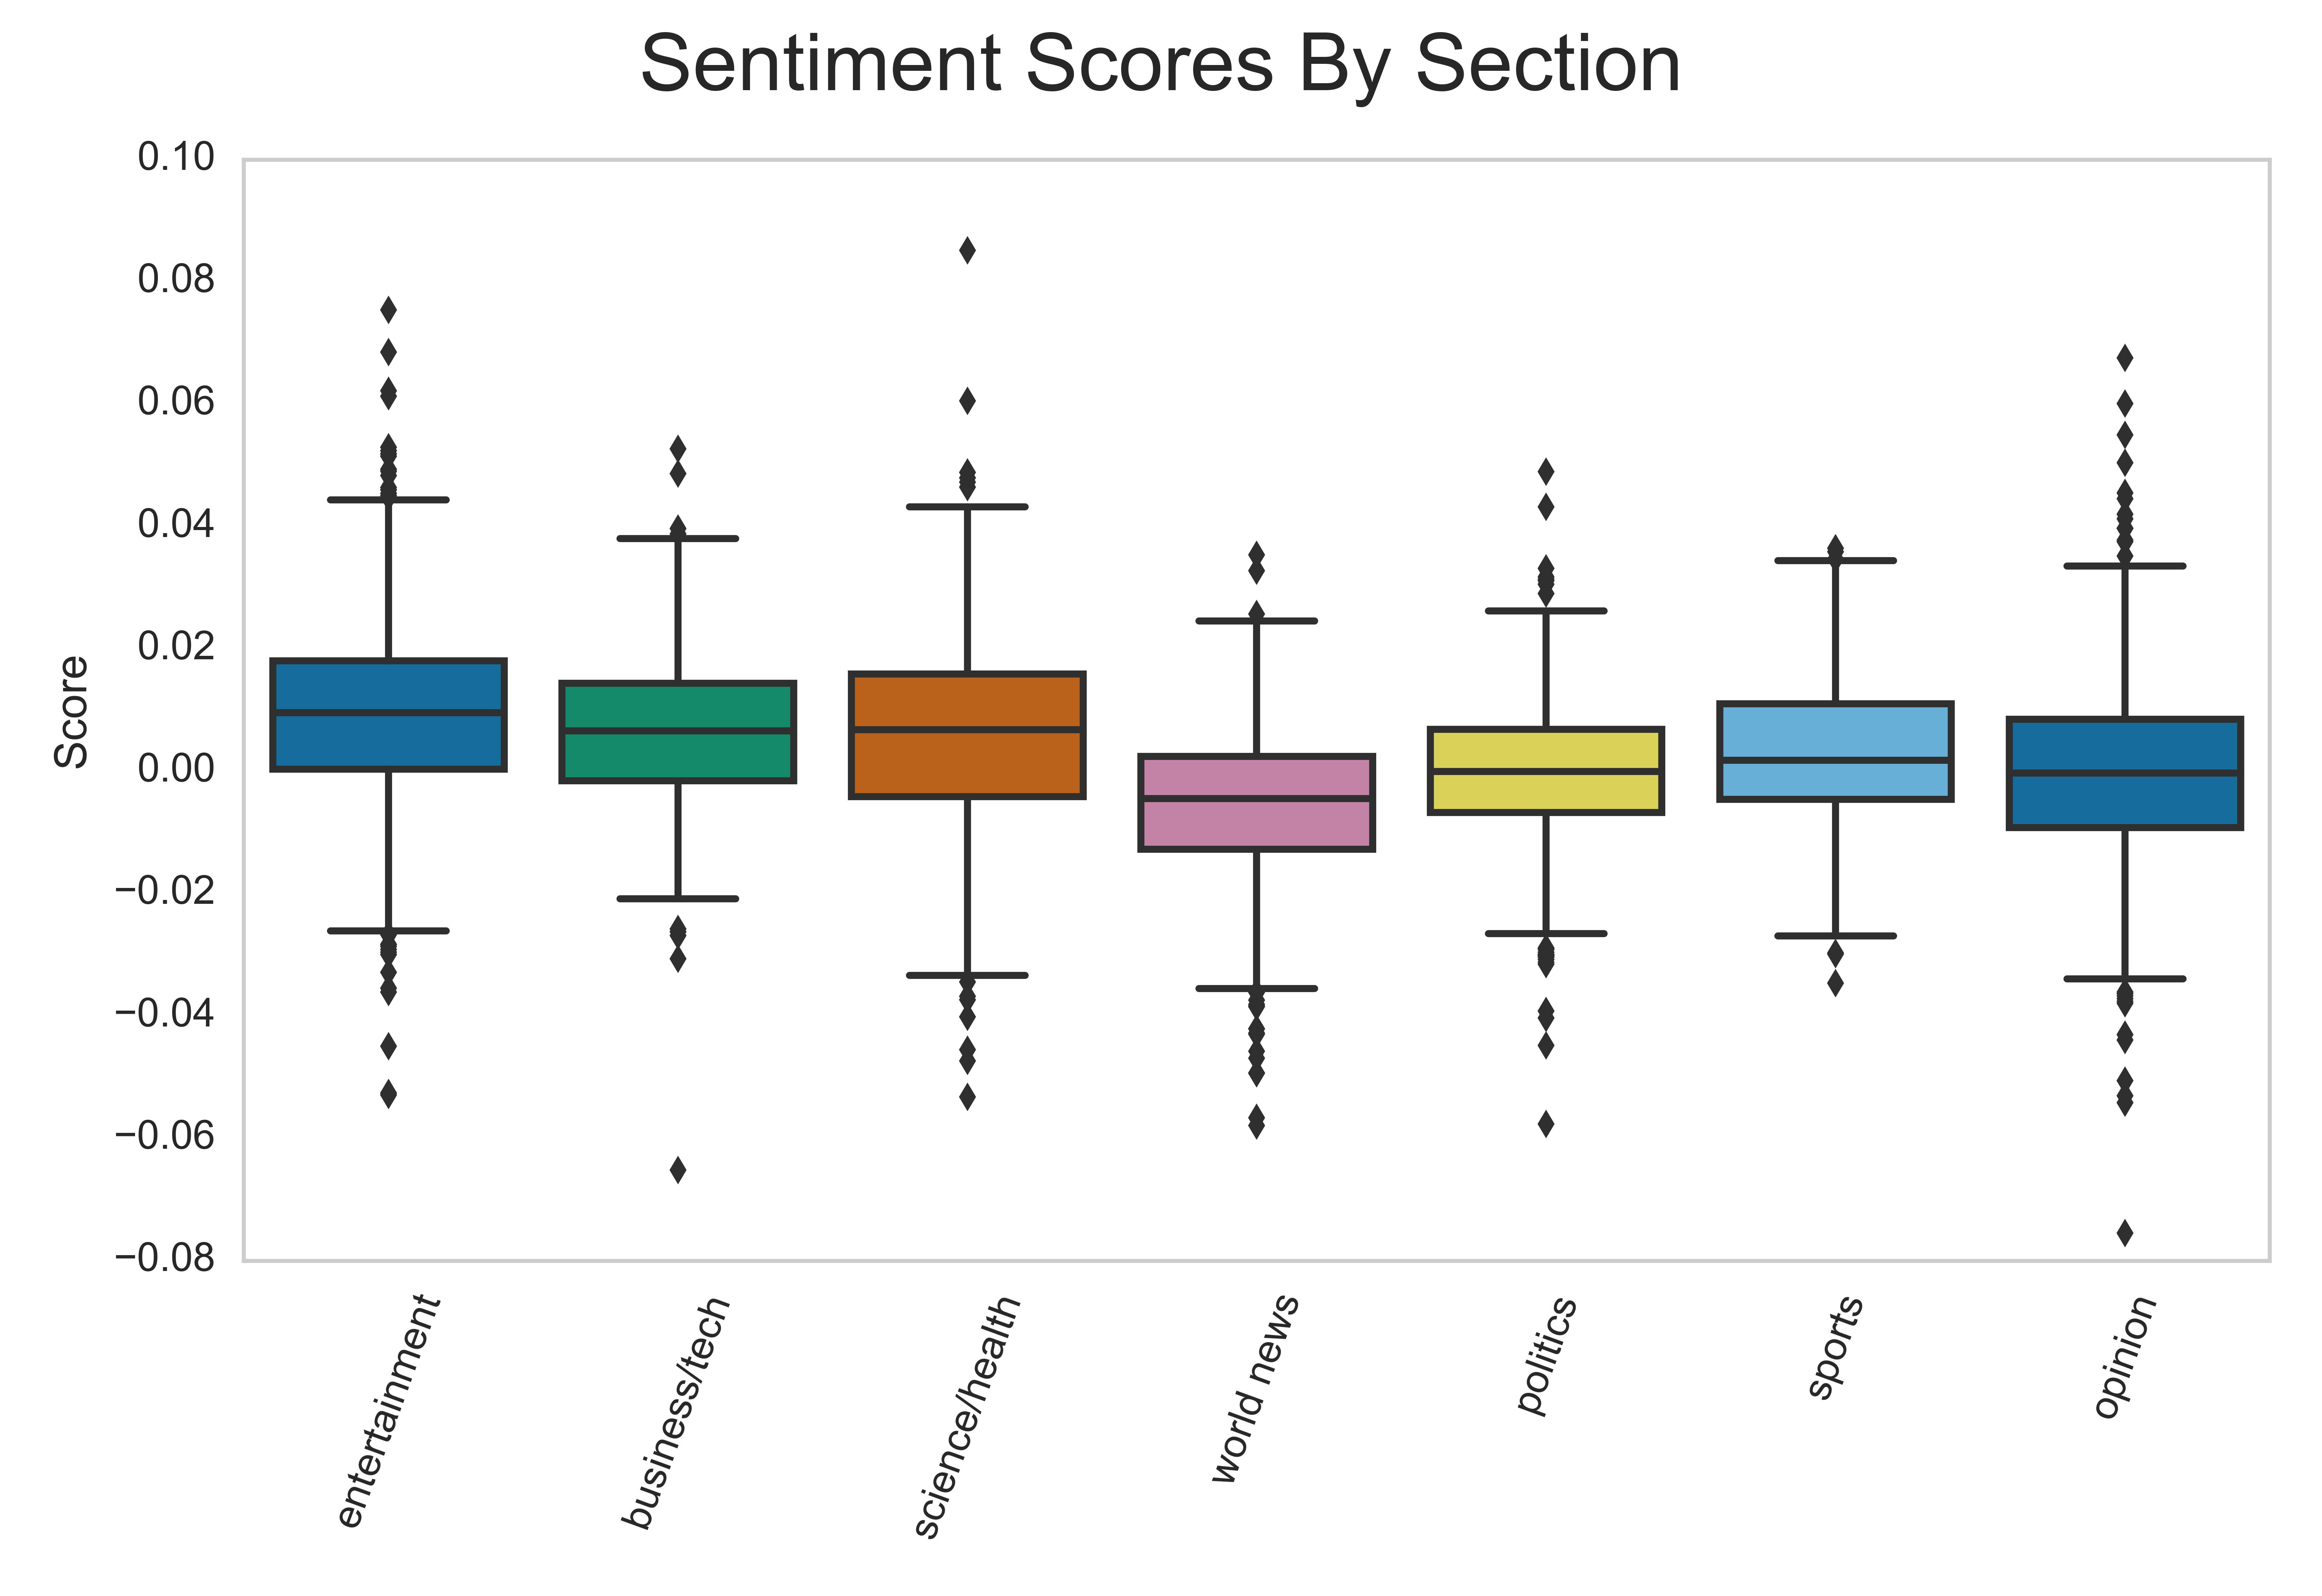

In [14]:
from IPython.display import Image
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/ss_boxplot.png')

## B. Named Entities

Overall, every section had more total (not unique) mentions of people than places, and of those, vastly more mentions of men than women. Sports, politics, and entertainment had the most person mentions, while world news had the most places. Entertainment had the most mentions of women.

By far, variants of America, the United States, and the U.S. were the most common place, and Donald Trump was the number one most common person in every section but sports.

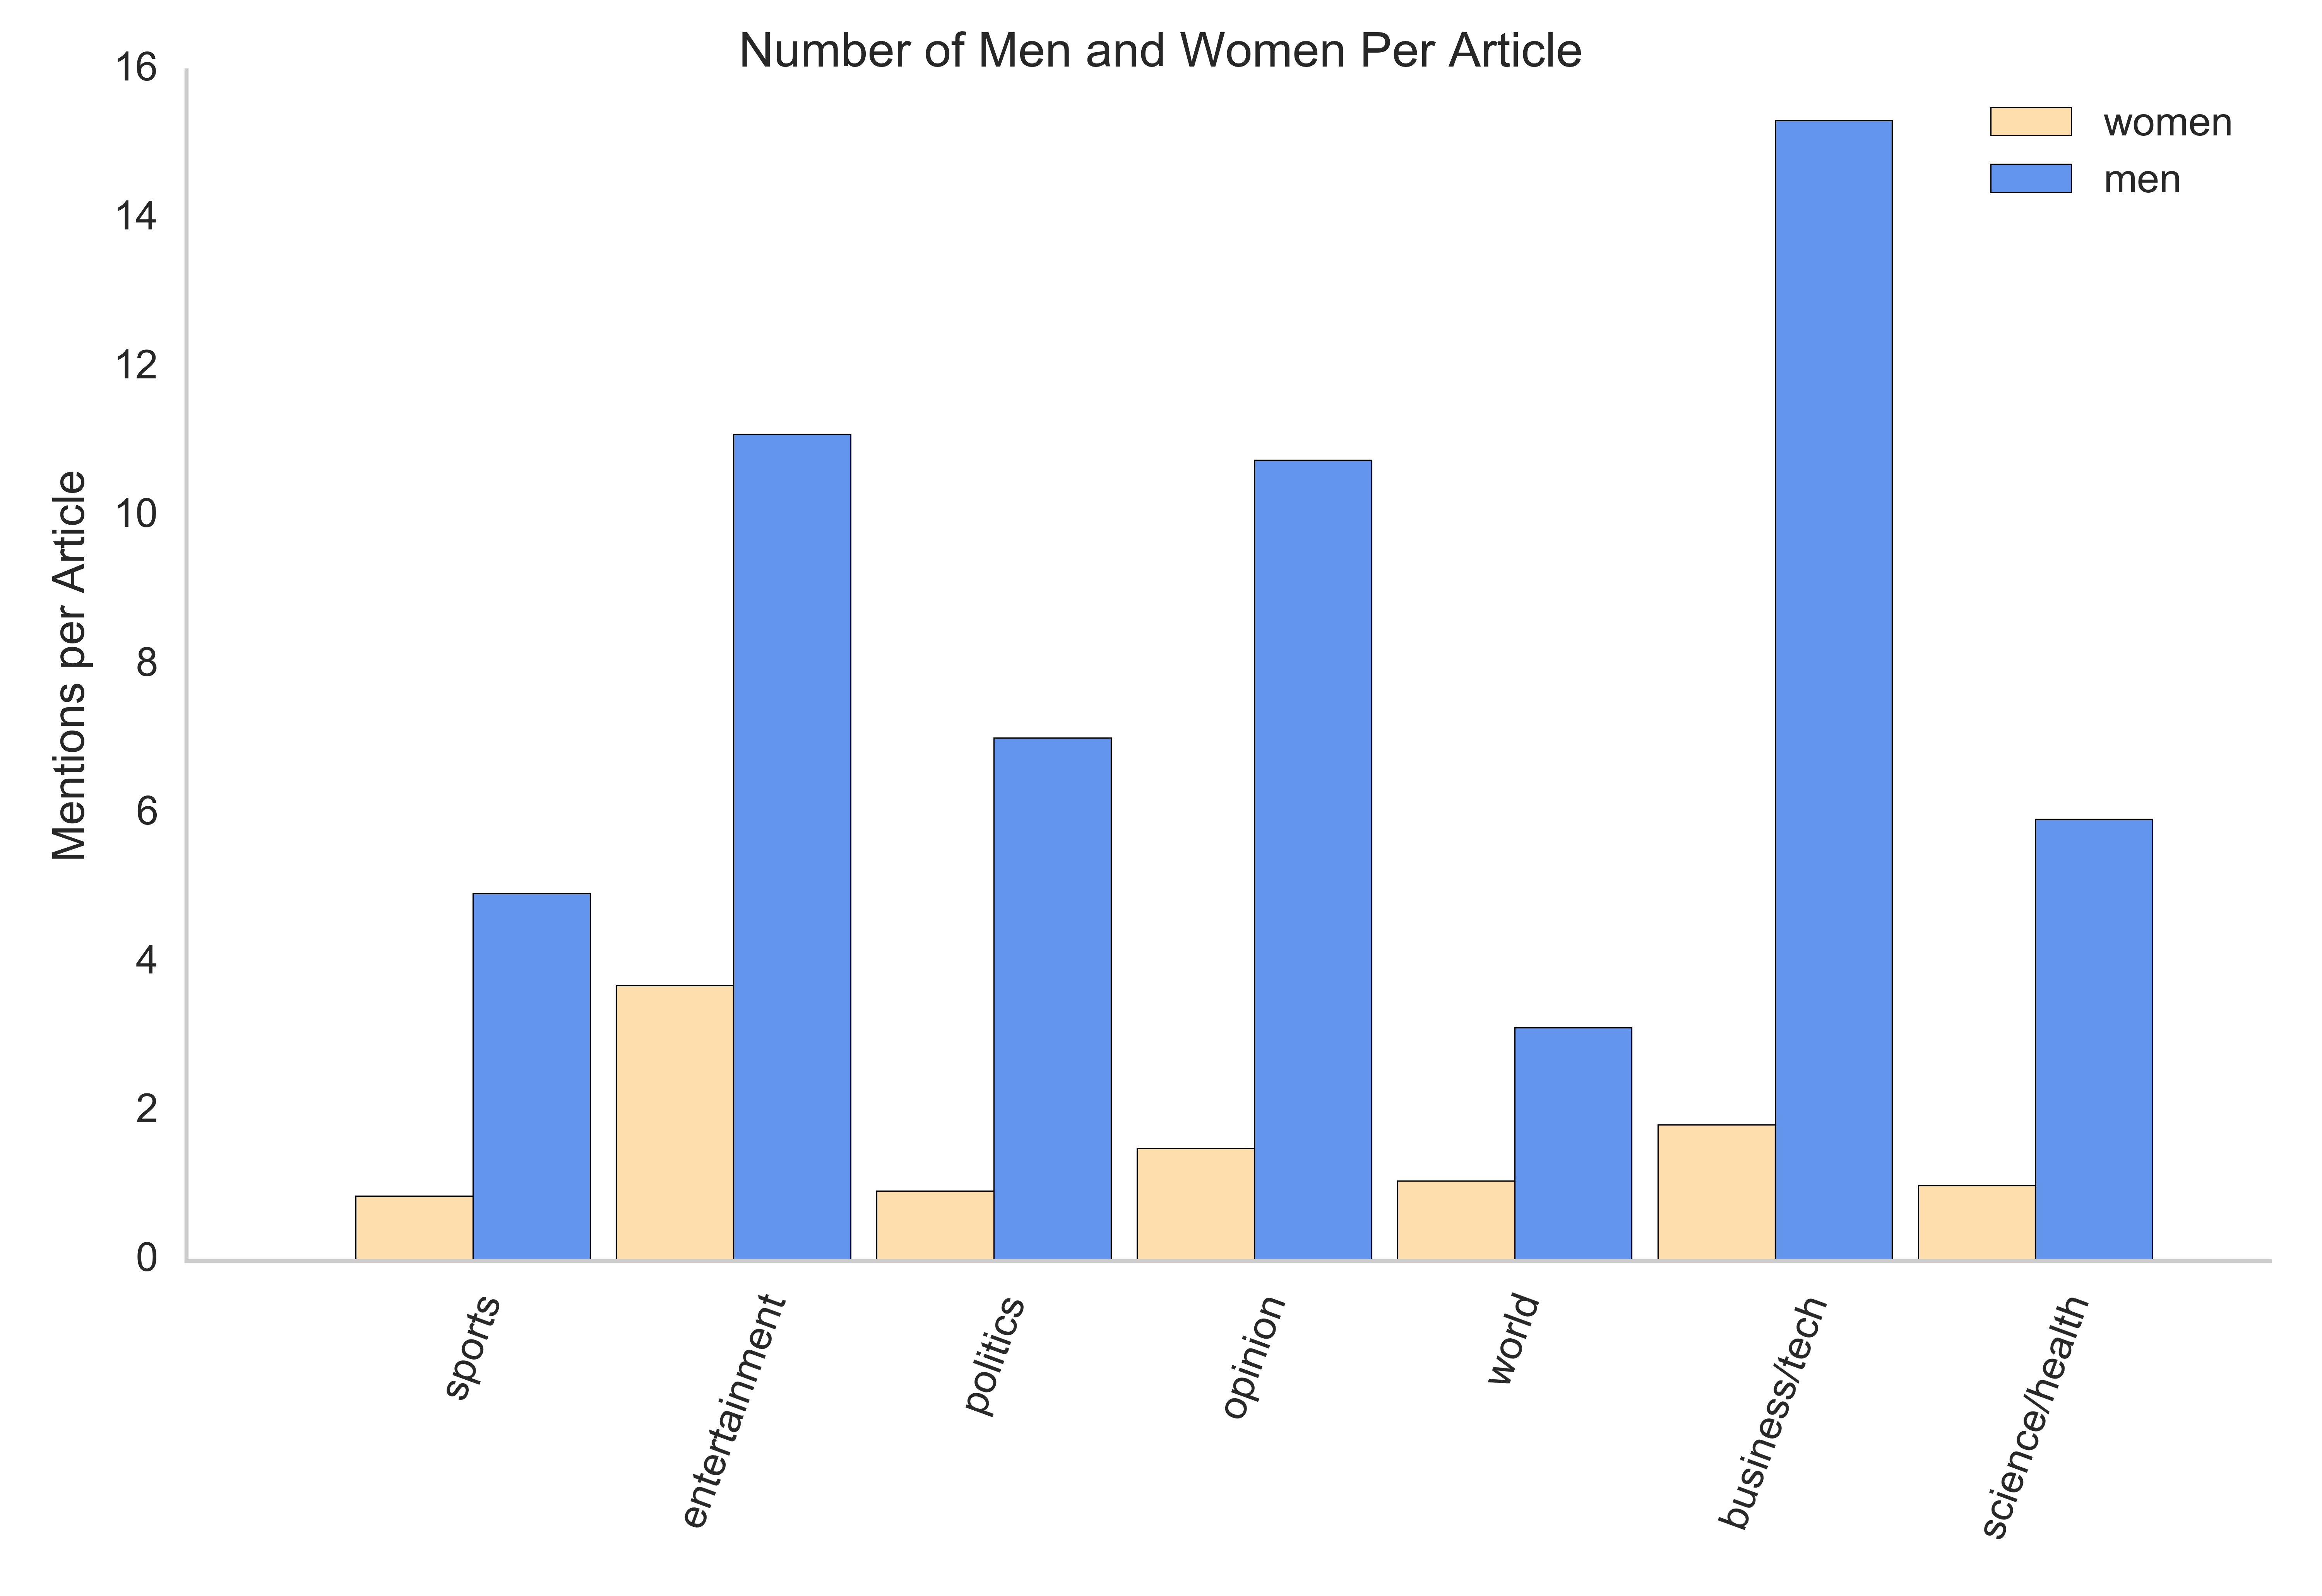

In [19]:
# graphs of people vs places and men vs women
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/mf_count.png')

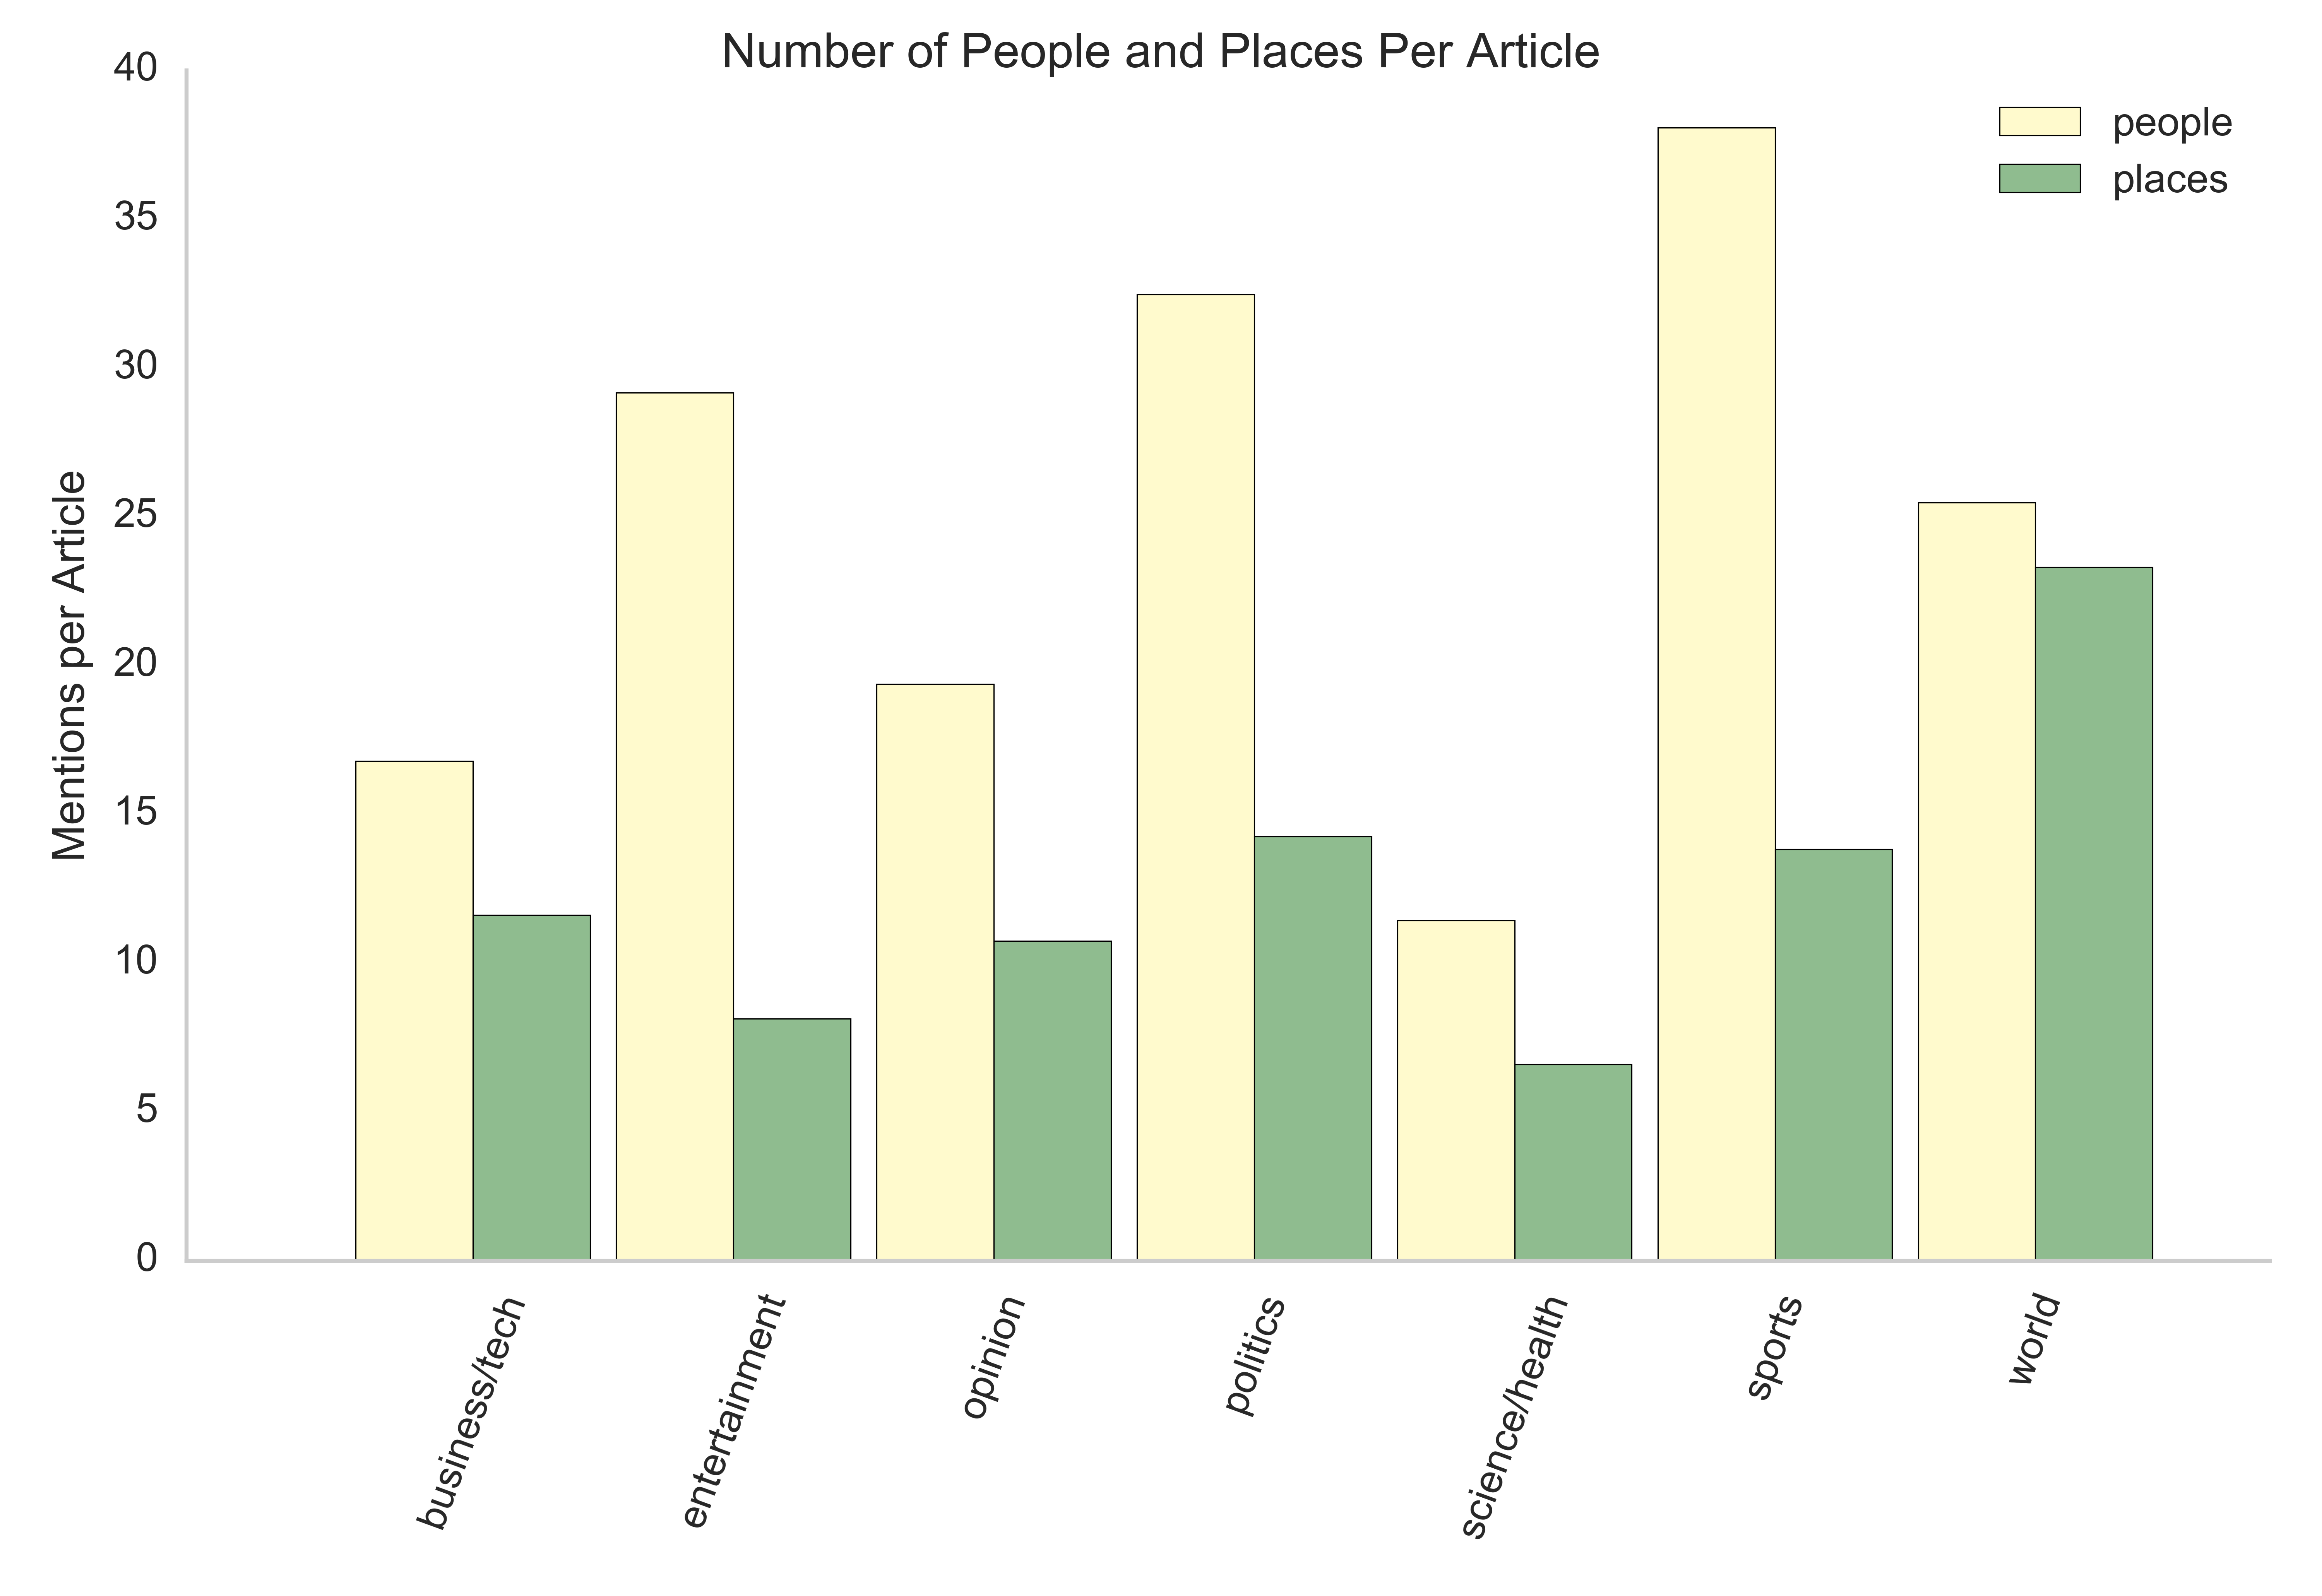

In [16]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/people_place_count.png')

## C. Plotting with HighCharts

In [17]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import json
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.util import *
from nltk.corpus import sentiwordnet as swn
from nltk.tag.perceptron import PerceptronTagger
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import os
import re

'''
Usage:

data = ArticleData().call()

sp = SentimentPlotter(data = data).call()
# returns a dataframe with sentiment scores for all articles, suitable for EDA
sp.get_highcharts_series(topic = 'Trump', date = datetime(2017,1,1))
# returns series in Javascript arrays for plotting with Highcharts

'''

class SentimentPlotter():
    def __init__(self, data = None):
        self.data = data

    def call(self):

        self.data['SA_body'] = [self.compute_score(x) for x in self.data['body']]
        self.data['SA_title'] = [self.compute_score(x) for x in self.data['title']]

        return self

    def get_highcharts_series(self, section = None, source = None, topic = None, date = None):
        self.section = section
        self.source = source
        self.topic = topic
        self.date = date

        self.range_date_dict, self.groupings = self.make_dict()

        self.x_dates, self.y_means, self.error_pairs, self.date_list = self.get_plotting_data()

        self.spline_series = self.get_spline_series()

        self.error_bar_series = self.get_error_bar_series()

        self.min_titles, self.max_titles = self.get_titles()

        self.min_scatter_series, self.max_scatter_series = self.get_scatter_points()

        return self.spline_series, self.error_bar_series, self.min_scatter_series, self.max_scatter_series


    def compute_score(self, sentence):
        tagger = PerceptronTagger()
        taggedsentence = []
        sent_score = []
        taggedsentence.append(tagger.tag(sentence.split()))
        wnl = nltk.WordNetLemmatizer()
        for idx, words in enumerate(taggedsentence):
            for idx2, t in enumerate(words):
                newtag = ''
                lemmatizedsent = wnl.lemmatize(t[0])
                if t[1].startswith('NN'):
                    newtag = 'n'
                elif t[1].startswith('JJ'):
                    newtag = 'a'
                elif t[1].startswith('V'):
                    newtag = 'v'
                elif t[1].startswith('R'):
                    newtag = 'r'
                else:
                    newtag = ''
                if (newtag != ''):
                    synsets = list(swn.senti_synsets(lemmatizedsent, newtag))
                    score = 0.0
                    if (len(synsets) > 0):
                        for syn in synsets:
                            score += syn.pos_score() - syn.neg_score()
                        sent_score.append(score / len(synsets))
            if (len(sent_score)==0 or len(sent_score)==1):
                return (float(0.0))
            else:
                return (sum([word_score for word_score in sent_score]) / (len(sent_score)))


    def make_dict(self):
        # define masks
        section_mask = (self.data['condensed_section'] == self.section)
        source_mask = (self.data['source'] == self.source)
        date_mask = (self.data['date'] > self.date)

        # initialize lists for plot_date_dict
        topic_scores = []
        dates = []
        groupings = []

        # initialize other dict
        range_date_dict = {}

        if not self.date:
            print "Please select a start date."

        # make plot_date_dict from appropriate subset of data
        else:
            if self.section and self.source:
                masked_data = self.data[section_mask & source_mask & date_mask]

            elif self.section and (not self.source):
                masked_data = self.data[section_mask & date_mask]

            elif self.source and (not self.section):
                masked_data = self.data[source_mask & date_mask]

            else:
                masked_data = self.data[date_mask]

            for i, row in masked_data.iterrows():

                if self.topic in row[2]:
                    topic_scores.append(row[6]) #body score
                    dates.append(row[1])
                    score_title_date = (row[0], row[1], row[6])
                    groupings.append(score_title_date)


                    # add to range_date_dict where keys are the dates and the values are a list of scores
                    if row[1] not in range_date_dict.keys():
                        range_date_dict[row[1]] = [row[6]]

                    elif row[1] in range_date_dict.keys():
                        (range_date_dict[row[1]]).append(row[6])
                return range_date_dict, groupings


    def get_plotting_data(self):
        # get dates for x-axis
        date_list = self.range_date_dict.keys()
        date_list.sort()
        x_dates = [x.value// 10 ** 6 for x in date_list]

        # y-values
        y_values = [np.mean(self.range_date_dict[x]) for x in date_list]

        # error bars
        error_min_max = []
        for x in date_list:
            temp_list = []
            minimum = min(self.range_date_dict[x])
            maximum = max(self.range_date_dict[x])
            temp_list.append(minimum)
            temp_list.append(maximum)
            error_min_max.append(temp_list)

        return x_dates, y_values, error_min_max, date_list

    def get_spline_series(self):
        # format splines for jsfiddle - do this first!
        d = []
        series = {'name': 'Mean Score', 'type': 'spline'}
        for x in range(len(self.date_list)):
            data_point = [self.x_dates[x], self.y_means[x]]
            d.append(data_point)
        series['data'] = d
        spline_series = json.dumps(series)
        return spline_series

    def get_error_bar_series(self):
        d = []
        series = {'color': '#FF0000', 'name': 'Range', 'type': 'errorbar', 'stemWidth': 3, 'whiskerLength': 0}
        for x in range(len(self.date_list)):
            data_point = [self.x_dates[x], self.error_pairs[x][0], self.error_pairs[x][1]]
            d.append(data_point)
        series['data'] = d
        error_series = json.dumps(series)
        return error_series

    def get_titles(self):
        min_score_titles = {}
        max_score_titles = {}

        # min scores
        for x in self.groupings:
            if x[1] not in min_score_titles.keys():
                min_score_titles[x[1]] = (x[2], x[0])
            elif x[1] in min_score_titles.keys():
                if x[2] < min_score_titles[x[1]][0]:
                    min_score_titles[x[1]] = (x[2], x[0])
                elif x[2] >= min_score_titles[x[1]][0]:
                    continue

        # max scores
        for x in self.groupings:
            if x[1] not in max_score_titles.keys():
                max_score_titles[x[1]] = (x[2], x[0])
            elif x[1] in max_score_titles.keys():
                if x[2] > max_score_titles[x[1]][0]:
                    max_score_titles[x[1]] = (x[2], x[0])
                elif x[2] <= max_score_titles[x[1]][0]:
                    continue

        min_titles = [min_score_titles[x][1].encode('ascii', 'ignore') for x in self.date_list]
        max_titles = [max_score_titles[x][1].encode('ascii','ignore') for x in self.date_list]

        return min_titles, max_titles

    def get_scatter_points(self):
        max_series = []

        for x in range(len(self.date_list)):
            data_point = {'showInLegend': False, 'type': 'scatter', 'color': '#FF0000',
                          'marker': {'symbol': 'circle', 'enabled': True, 'color': '#FF0000'},
                          'tooltip': {'pointFormat': '{point.y}'}}

            data_point['name'] = self.max_titles[x]

            data_list = [[self.x_dates[x], self.error_pairs[x][1]]]

            data_point['data'] = data_list
            max_series.append(data_point)

        max_series = json.dumps(max_series)

        # return minimum scatter points series
        min_series = []

        for x in range(len(self.date_list)):
            data_point = {'showInLegend': False, 'type': 'scatter', 'color': '#FF0000',
                          'marker': {'symbol': 'circle', 'enabled': True, 'color': '#FF0000'},
                          'tooltip': {'pointFormat': '{point.y}'}}
            # get title
            data_point['name'] = self.min_titles[x]

            data_list = [[self.x_dates[x], self.error_pairs[x][0]]]

            data_point['data'] = data_list

            min_series.append(data_point)

        min_series = json.dumps(min_series)

        return min_series, max_series
    
    # makes a static plot with error bars for sentiment scores on topic
    def plot_time(self):

        x = self.range_date_dict.keys()
        x.sort()
        ordered_x = []
        y = []
        for val in x:
            ordered_x.append(val)
            values = self.range_date_dict[val]
            mean = np.mean(values)
            y.append(mean)

        # define upper and lower boundaries for error bars
        upper_bounds = [max(self.range_date_dict[x]) for x in ordered_x]
        lower_bounds = [min(self.range_date_dict[x]) for x in ordered_x]

        # define distance for upper error bar
        y_upper = zip(y, upper_bounds)
        upper_error = [abs(pair[0] - pair[1]) for pair in y_upper]

        # define distance for lower error bar
        y_lower = zip(y, lower_bounds)
        lower_error = [abs(pair[0] - pair[1]) for pair in y_lower]

        asymmetric_error = [lower_error, upper_error]

        plt.plot(ordered_x, y, c = 'r', marker = 'o')
        plt.errorbar(ordered_x, y, yerr = asymmetric_error, ecolor = 'r', capthick = 1)
        plt.xlim(min(ordered_x) + timedelta(days = -1), max(ordered_x) + timedelta(days = 1))
        plt.xticks(rotation = 70)
        plt.show()

# V. Feature Selection

Since the TfidfVectorizer yielded approximately 119,000 unigrams and bigrams, feature reduction was necessary. Since every unique word in a document can represent a new feature, it's important to identify which words are the most informative and train a model on those, discarding the less informative words in order to reduce dimensionality, save computational bandwidth, and reduce overfitting. In addition, for a classifier to work on new articles that may contain words it's never seen before, having a set vocabulary can help prevent an error. Considering the enormity of the English vocabulary and the relatively small size of my corpus, it's unlikely that I'll have developed the optimal vocabulary for news classification, and to improve accuracy, this vocabulary could be grown and improved if the project had a longer lifespan.

## A. PCA

I tried a Principal Component Analysis and found that 80% of variance in the data could be explained with around 500 principal components, and over 90% could be explained with 800 principal components. However, when I fit a Naive Bayes classifier using 800 principal components, accuracy was only 56%. This low score, plus the loss of interpretability of the principal components made PCA less appealing than other dimensionality reduction methods.

In [ ]:
# graph from PCA

## B. SelectKBest

I had read that the chi2 criterion was useful in feature selection for text classification tasks, so used Sci-kit Learn's SelectKBest class with k ranging from 100 to the full feature set and the chi2 scoring function, and assessed performance using a Multinomial Naive Bayes classifier. Accuracy began to plateau with around 5000 features, so I built a vocabulary based on the top 5000 most informative features.

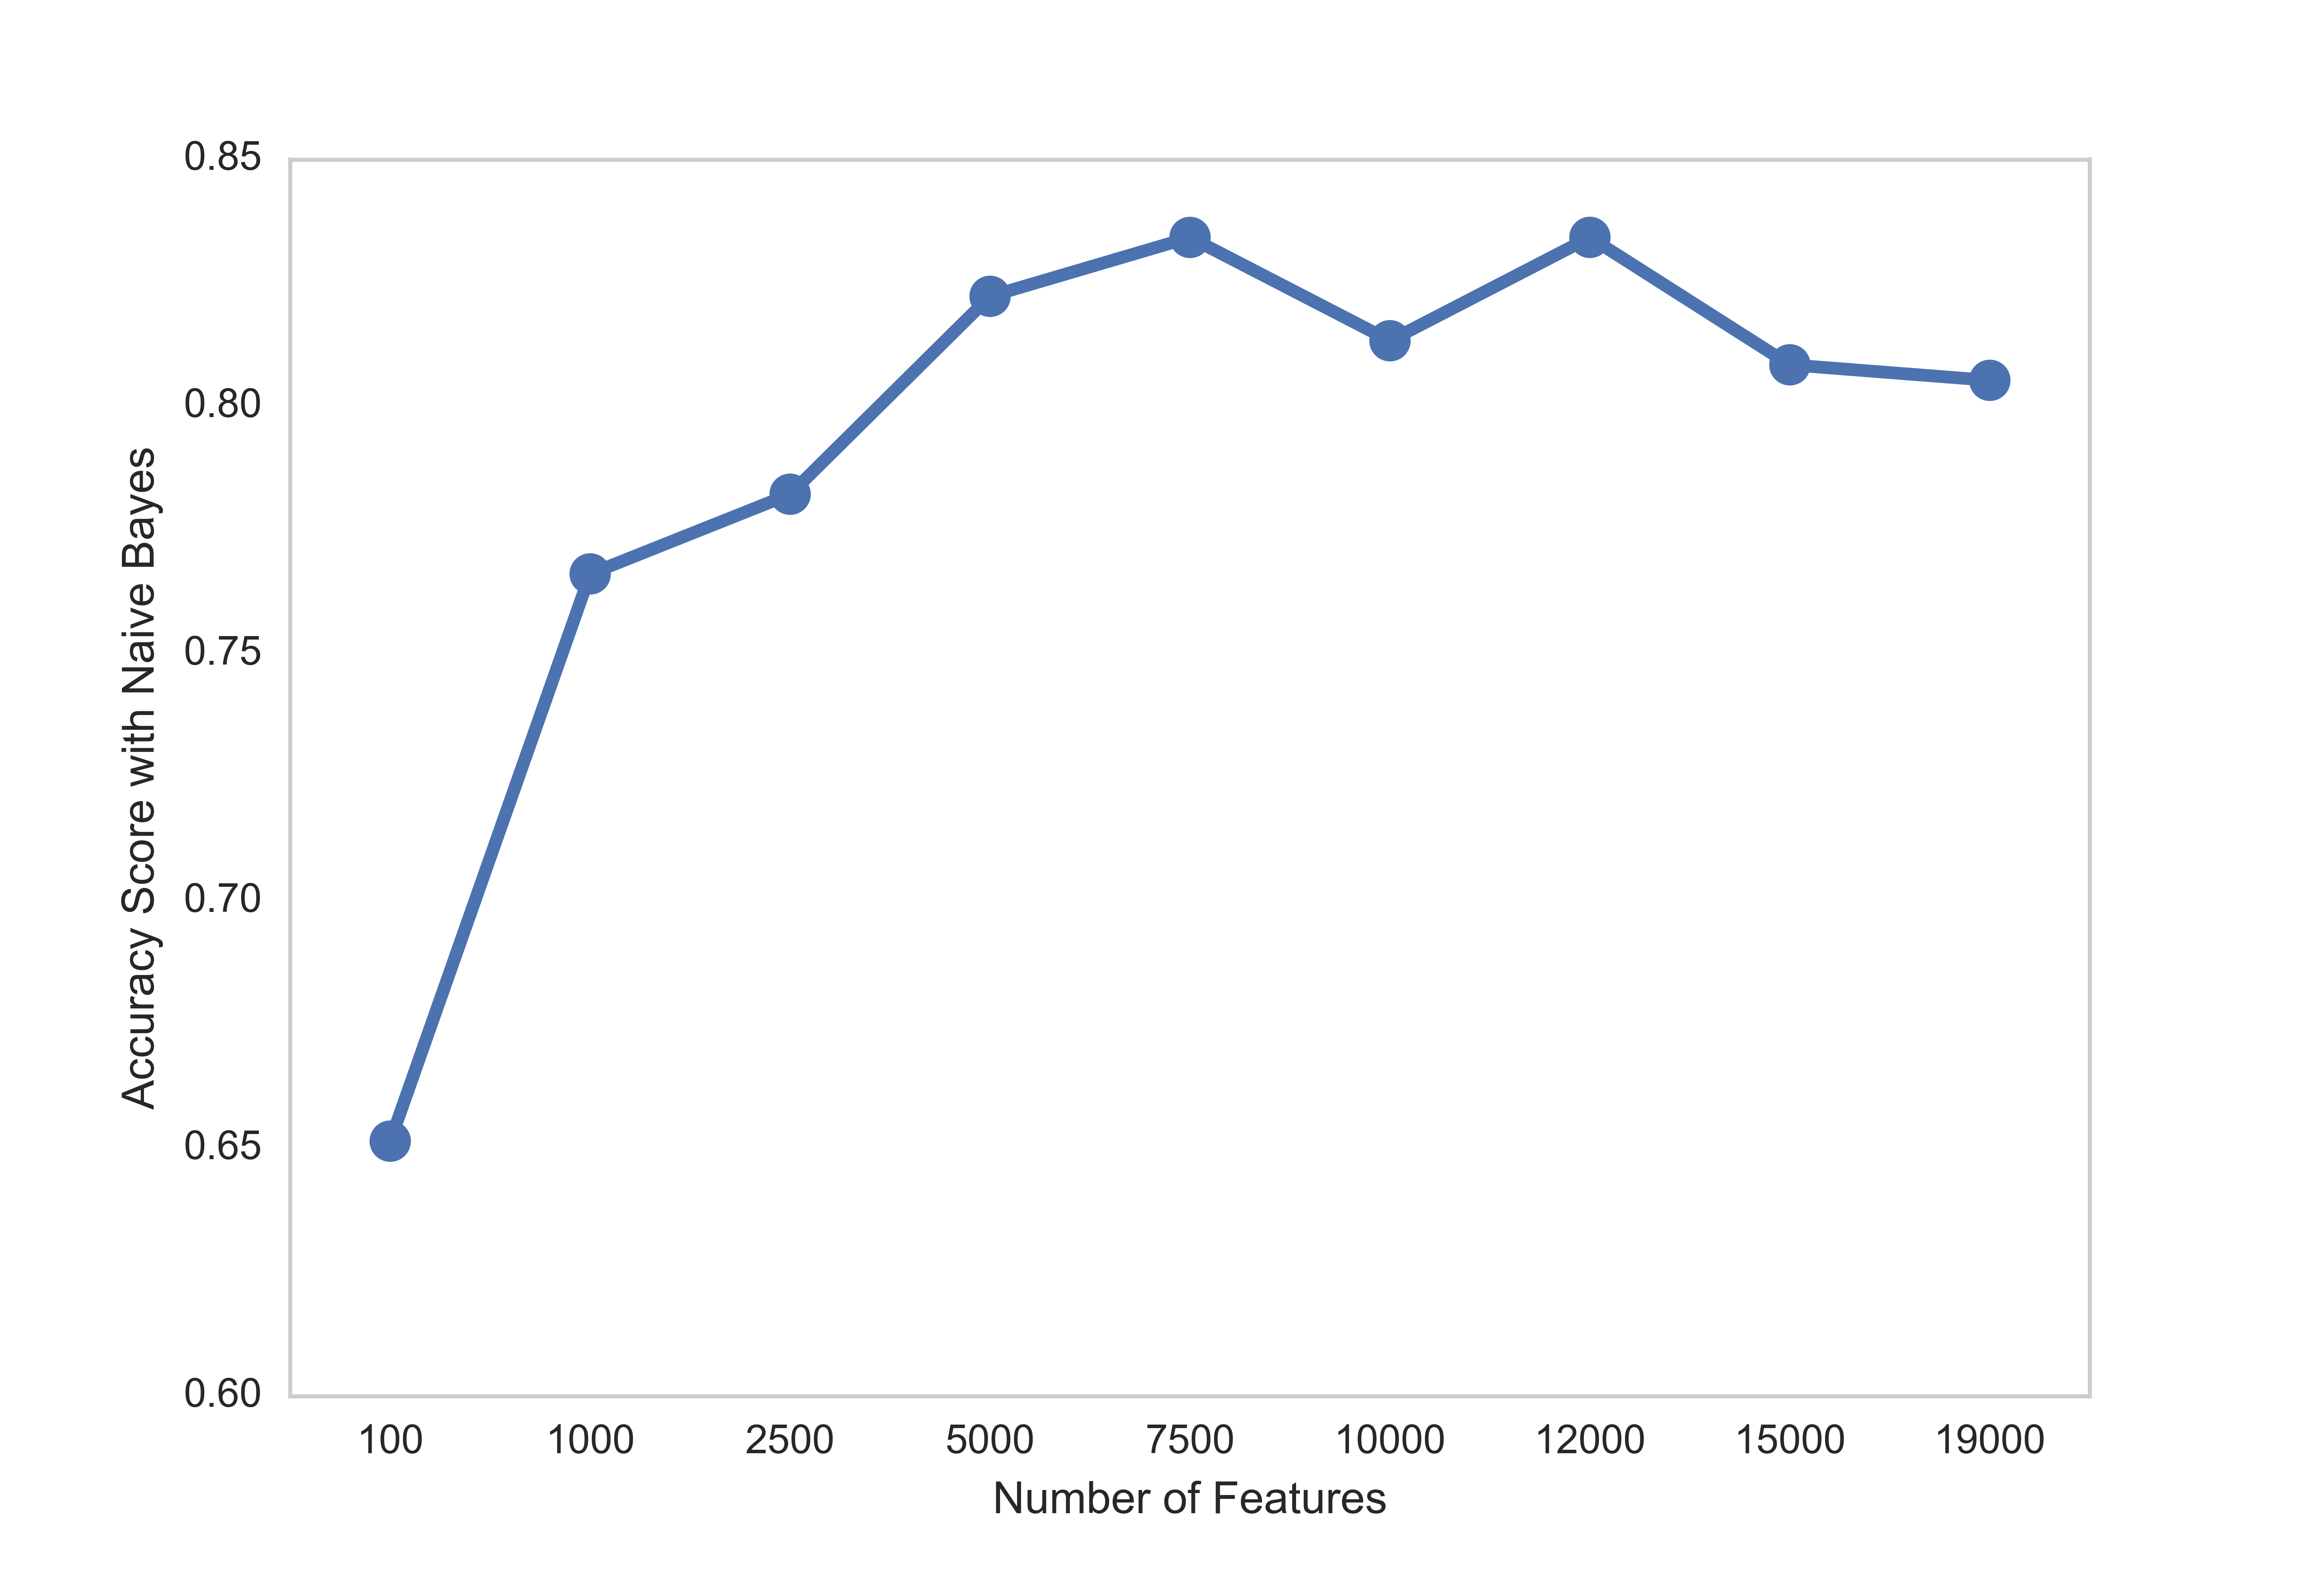

In [20]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/feature_select.png')

These features are the most informative unigrams and bigrams, sorted by p-value. The chi2 score function assesses how unlikely the existing tf-idf scores would be if terms were distributed among the newspaper sections by chance. The most section-specific terms seem to be sports-related, though "researcher" and "company" may be specific to the science/health and business/tech sections respectively.

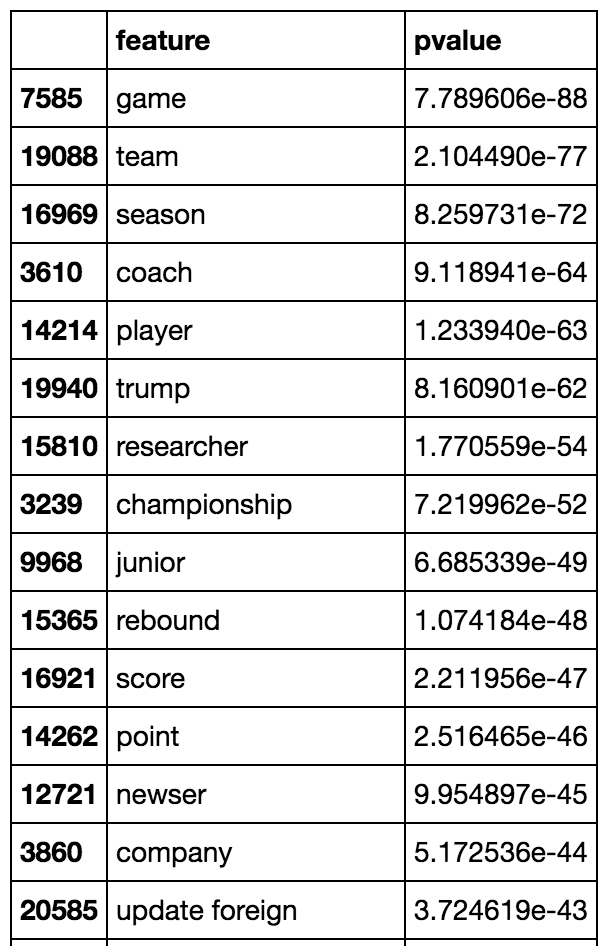

In [21]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/important_features.png')

# VI. Pipeline

The pipeline can be used to format any new articles for classification. It includes all necessary transformations on an ArticleData object, as well as a scaling step. However, the entire pipeline does not preserve column names, so it is unfit for exploratory data analysis. If column names need to be preserved, TitleTransformer and BodyTransformer can be applied separately, and their results concatenated with the 'condensed_section' column for analysis.


## A. ItemSelector

TitleTransformer and BodyTransformer are written to only perform operations on the 'title' and 'body' columns of an ArticleData object. Since the TfidfVectorizer need only be applied to the article bodies, I needed another transformer that could select a particular column and pass it on. ItemSelector can be combined with another more general Transformer in a sub-pipeline to apply a transformation to a subset of the total data.

In [ ]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y = None):
        return self

    def transform(self,X):
        return(X[self.key])

## B. The Complete Pipeline

All features are derived and combined in a FeatureUnion during the 'features' step: applying title and body transformations, tf-idf vectorizing with a vocabulary of the top 5000 words derived from K-Best selection ('bigram_vocab'), and a transformation to dense. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from mlxtend.preprocessing import DenseTransformer

pipe = Pipeline([('features', FeatureUnion([('t',TitleTransformer()),
                                            ('b', BodyTransformer()),
                                            ('tf-pipe', Pipeline([
                                            ('items', ItemSelector(key = 'body')),
                                           ('tfidf', TfidfVectorizer(preprocessor = tokenize, ngram_range = (1,2), 
                                                                     min_df = 10, vocabulary = bigram_vocab)),
                                           ('dense', DenseTransformer())])),
                    ])),
                 ('scale', MinMaxScaler())
                 ])

# use fit_transform to prepare data for model fitting
# Warning: takes several hours to run for 4000 articles
Xt = pipe.fit_transform(data)

# VII. Models

Naive Bayes is the go-to model for text classification tasks, as they are reasonably efficient and robust to errors, especially when the sample size is relatively small [1]. However, other viable options include decision trees, K-Nearest Neighbors, and Support Vector Machines.

I tested six models in total using Scikit-Learn: KNN (with k ranging from 5-50, here reporting the highest score at k = 10), a random forest classifier, Adaboost, SGDClassifier, BernoulliNB, and MultinomialNB. 

I witheld 30% of the data as a test set, and used a 5-fold cross-validated grid search to optimize hyperparameters for each model. The top two performers were Bernoulli Naive Bayes and Stochastic Gradient Descent Classifier (SVM) at about 85% accuracy. Interestingly, Multinomial Naive Bayes performed the worst, at only 32% accuracy. Multinomial Naive Bayes differs from Bernoulli Naive Bayes in that it assumes positional independence of tokens, or words in a document, which the data almost certainly violates.

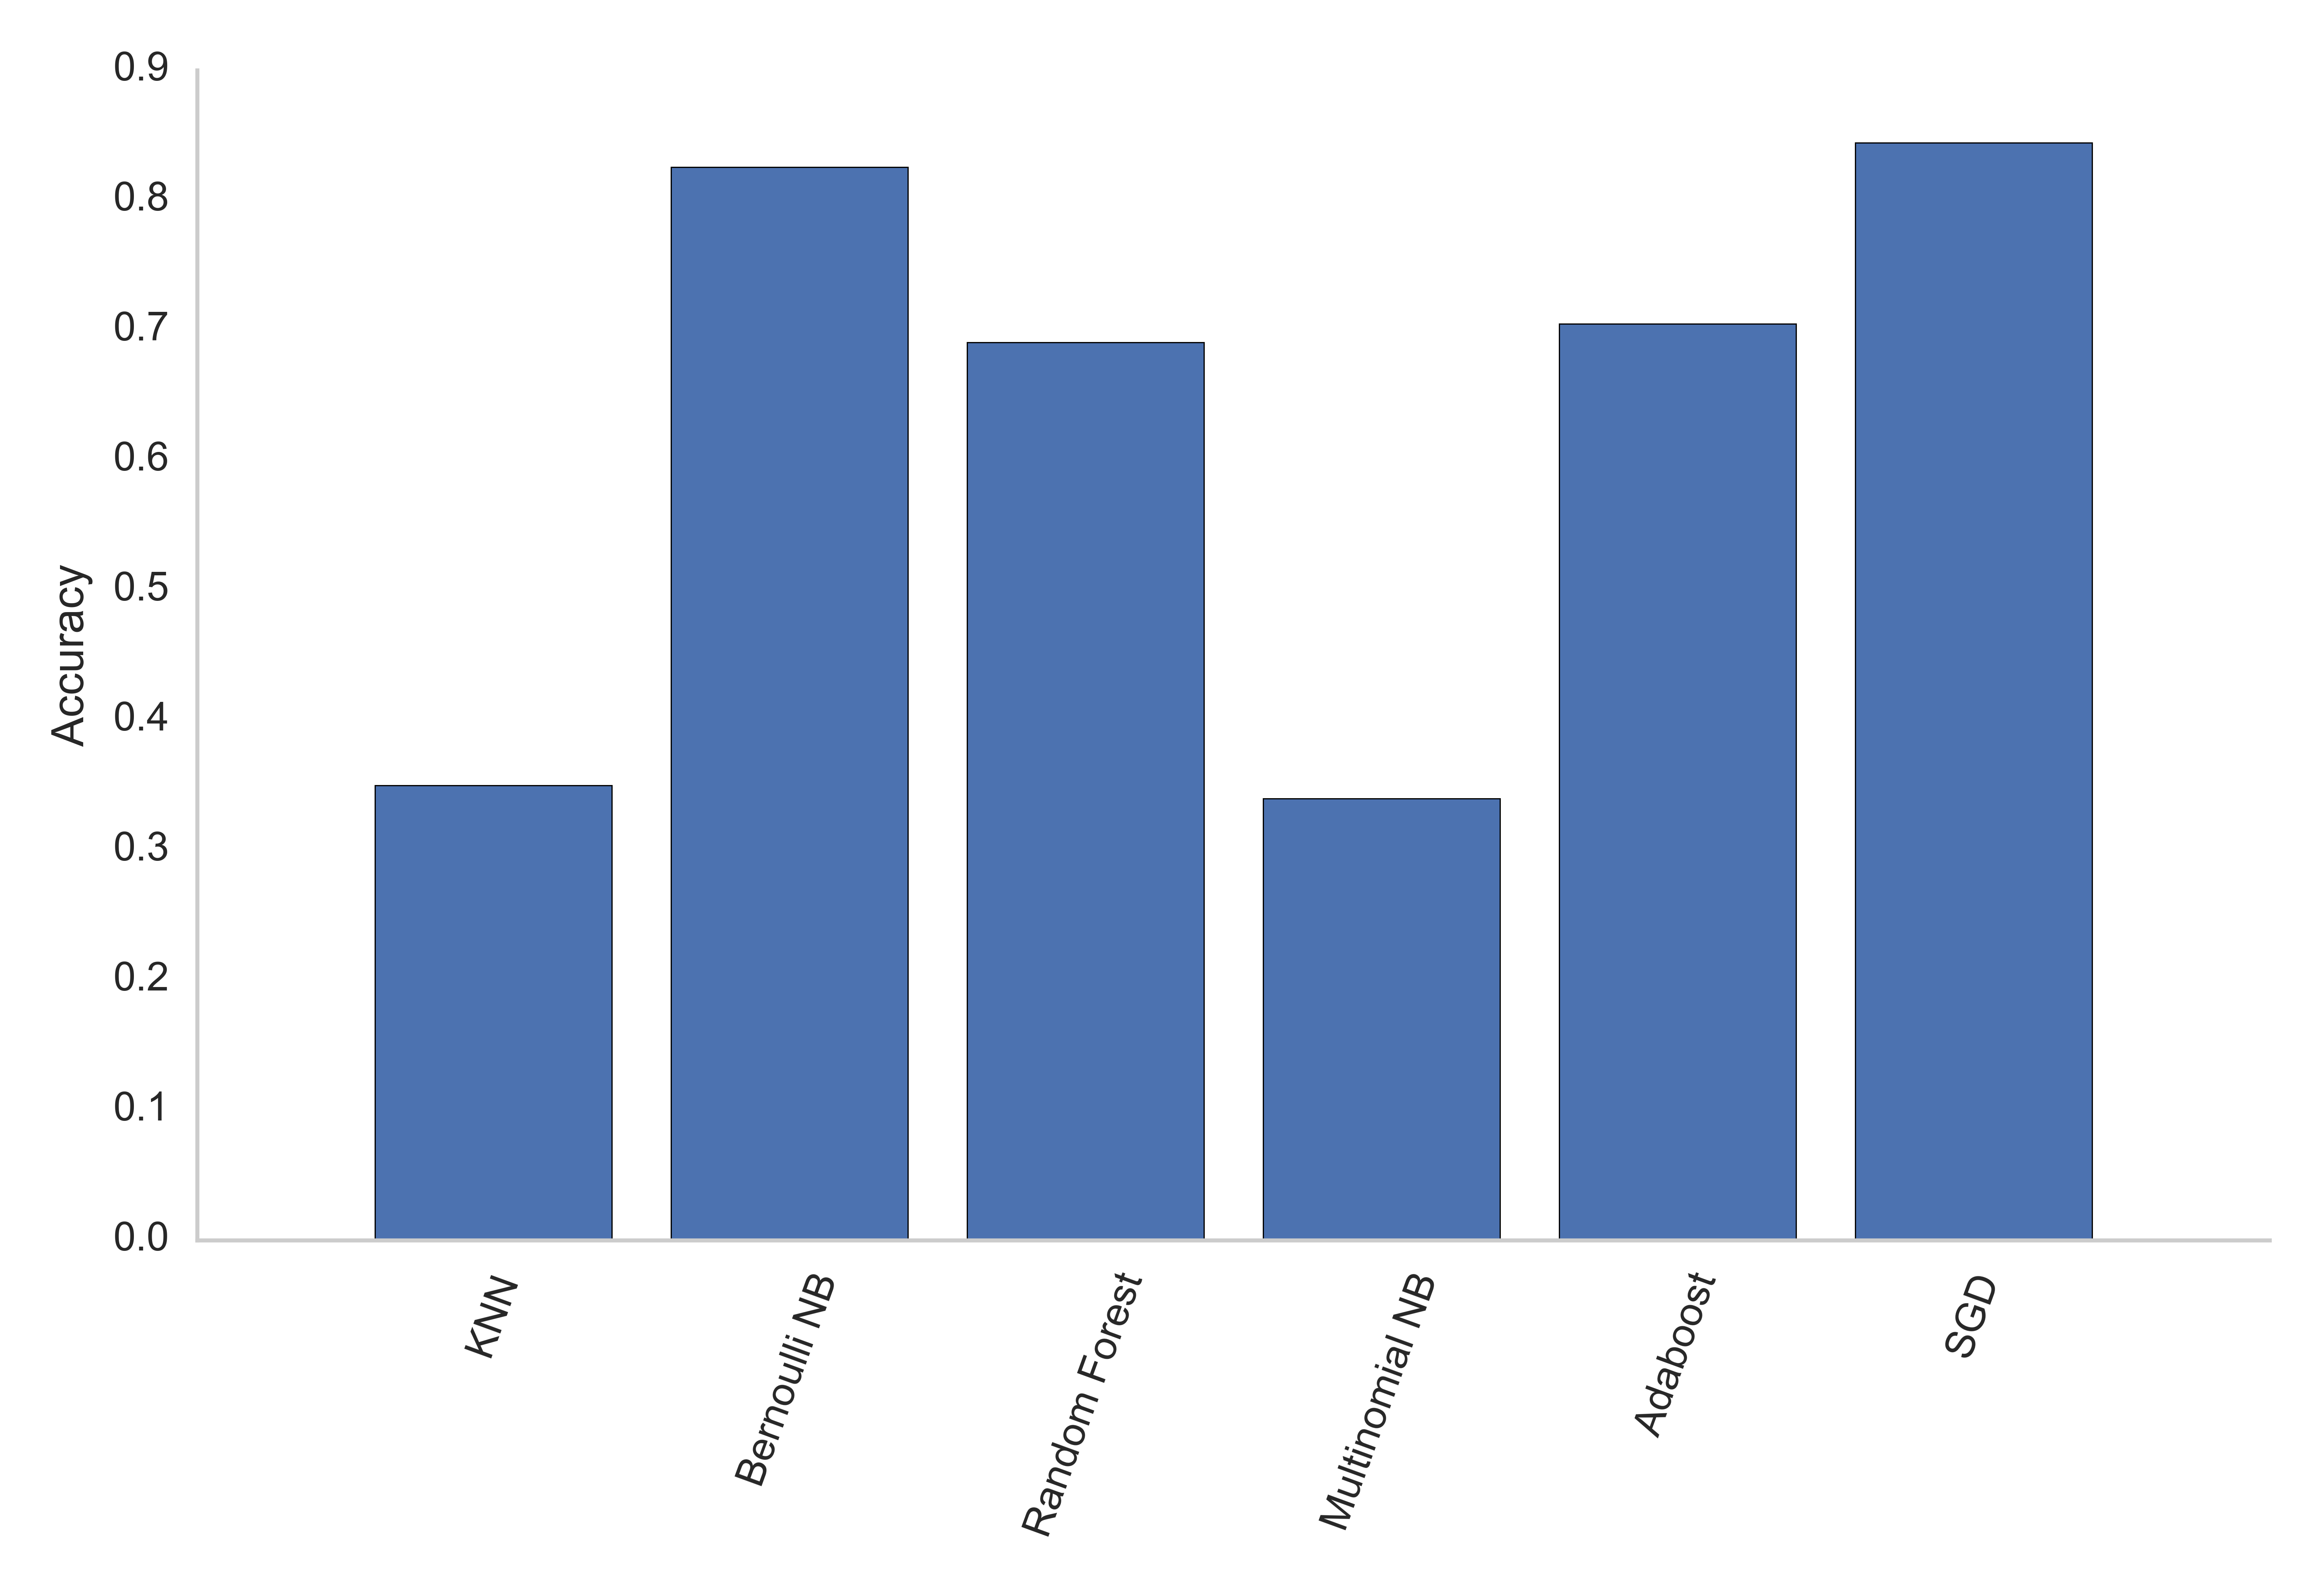

In [22]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/model_accuracy.png')

# VIII. Model Evaluation

Examining confusion matrices for each of the top two models, there are diagonal bands of high values indicating the correctly categorized articles. The most difficult section to classify appears to be business/technology, as it has the lowest f1-score for both classifiers, though the SGDClassifier slightly out-performs the Naive Bayes. The opinion section also appears to pose some challenges for both classifiers, as both have low recall scores for this section, meaning that many opinion pieces are misclassified into other sections. This seems like a natural mistake to make, as an opinion piece could be written about any topic, and therefore, topical feature words might be less informative.

## A. Bernoulli Naive Bayes

In [34]:
# what terms were most informative for each section?

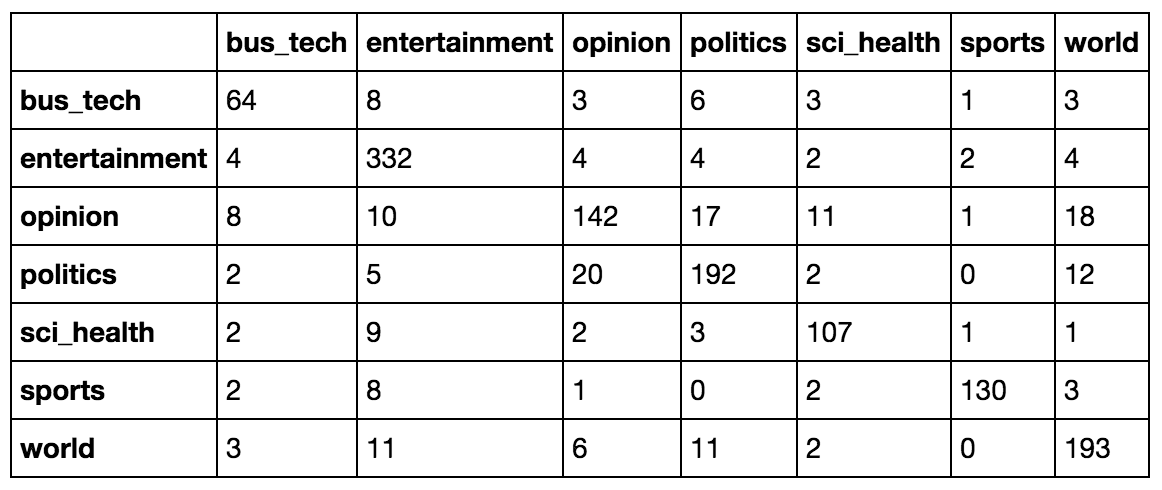

In [33]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/NB_conmat.png')

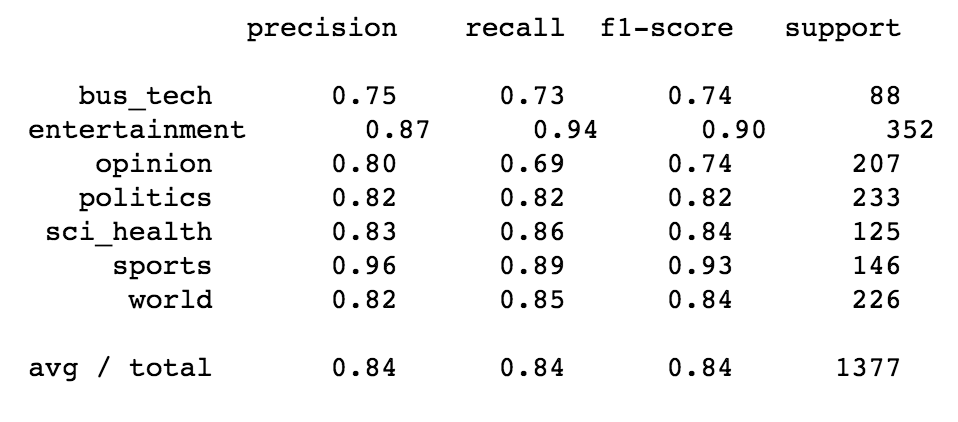

In [32]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/NB_class_report.png')

## B. SGDClassifier

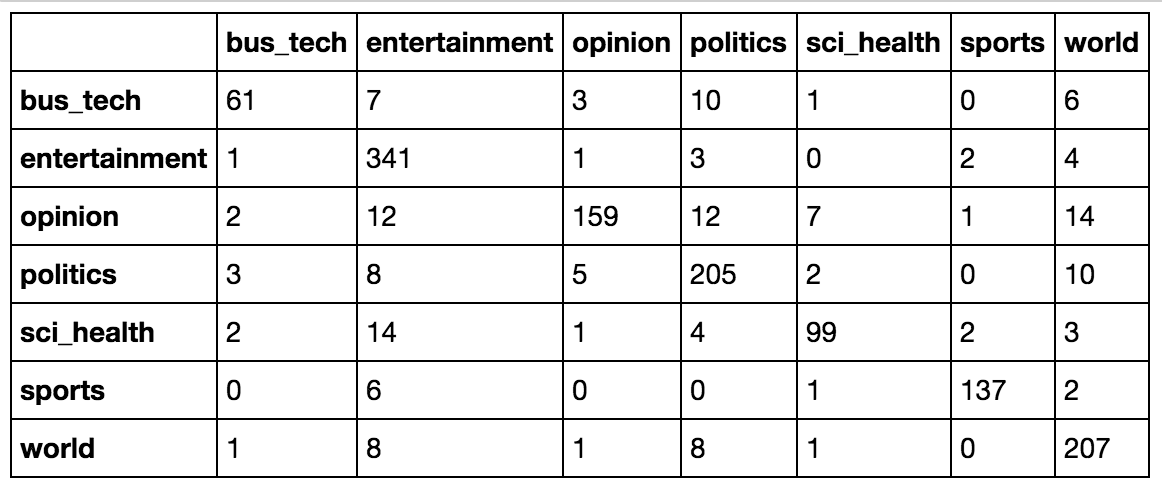

In [30]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/SGD_conmat.png')

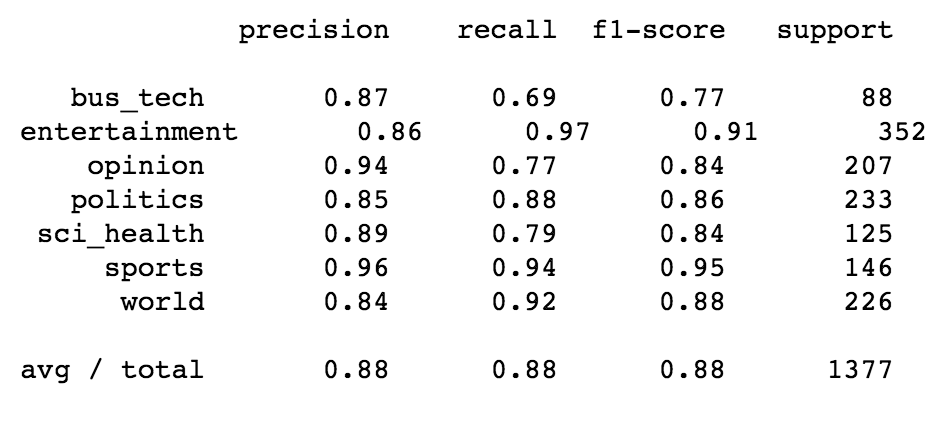

In [31]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/SGD_class_report.png')

# IX. Conclusions
 could use countvectorizer as well to improve accuracy
 look into cloud services to help performance

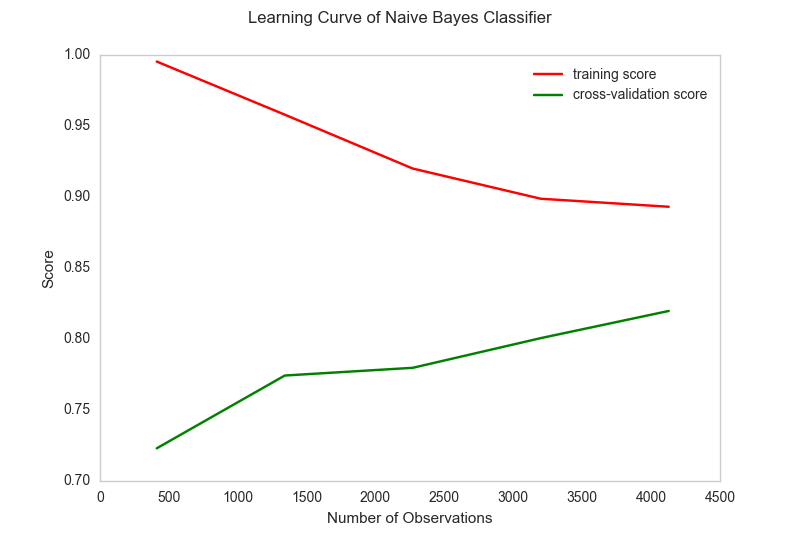

In [35]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/nb_learningcurve.png')

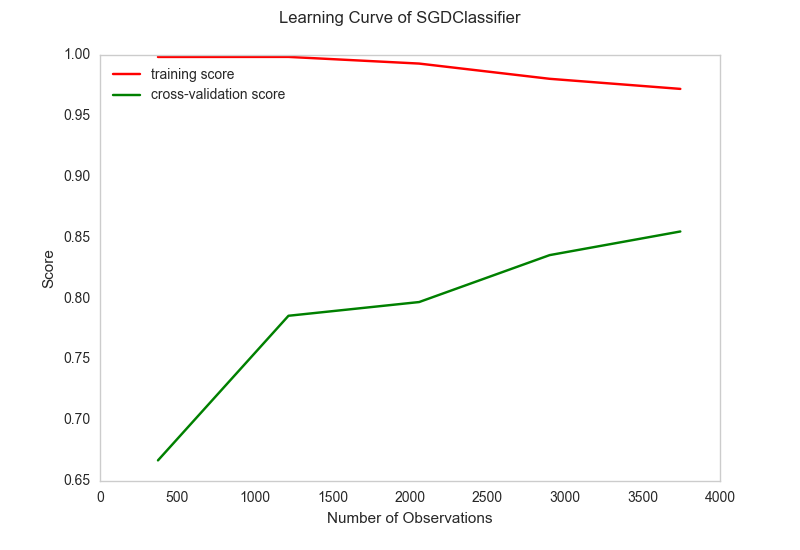

In [37]:
Image(filename = '/Users/teresaborcuch/capstone_project/presentation/sgd_learning_curve.png')

# X. References

[1] Manning, C.D., Raghavan, P., Schutze, H. 2009. Introduction to Information Retrieval Online Edition. Cambridge (UK). Cambridge University Press.

[2] Bengfort, Ben. Text Classification with NLTK and Scikit-Learn. Blog Post. *Libelli*, 19 May 2016. Web. Accessed 2017.